# 패키지 불러오기

In [1]:
import numpy as np
import pandas as pd
import json
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-whitegrid')
# import missingno
import re
import glob
import os

from scipy import stats
from scipy.integrate import trapz

# import missingno as msno

import sys
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 20, 'max_rows', 20, 'max_colwidth', 20)

In [2]:
# 알고리즘(시계열)
import statsmodels.api as sm
from scipy import stats
import pmdarima as pm
from pmdarima import model_selection

# 전처리
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import Binarizer
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Model selection
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer

# 차원축소
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## 알고리즘(회귀)
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.svm import SVR 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import statsmodels.api as sm

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
from sklearn.metrics import r2_score 

# 
from matplotlib.patches import Patch




from itertools import product
from tqdm import tqdm

# 데이터 읽기

In [3]:
raw_df = pd.read_csv(r'F:\OneDrive - 퍼즐데이터\01_sejin\01_Python\02_practice\05_time_series_analysis\OnlineTSA-master\Data\BikeSharingDemand\Bike_Sharing_Demand_Full.csv')

In [4]:
raw_df = pd.read_csv(r'C:\puzzledata\OneDrive - 퍼즐데이터\01_sejin\01_Python\02_practice\05_time_series_analysis\OnlineTSA-master\Data\BikeSharingDemand\Bike_Sharing_Demand_Full.csv')

# 데이터 확인

# 전처리

## 시계열 패턴 추출

In [ ]:
## Functinalize
### Feature engineering of default
def non_feature_engineering(raw):
    raw_nfe = raw.copy()
    if 'datetime' in raw_nfe.columns:
        raw_nfe['datetime'] = pd.to_datetime(raw_nfe['datetime'])
        raw_nfe['DateTime'] = pd.to_datetime(raw_nfe['datetime'])
    if raw_nfe.index.dtype == 'int64':
        raw_nfe.set_index('DateTime', inplace=True)
    # bring back
    # if raw_nfe.index.dtype != 'int64':
    #     raw_nfe.reset_index(drop=False, inplace=True)
    raw_nfe = raw_nfe.asfreq('H', method='ffill')
    return raw_nfe
# raw_rd = non_feature_engineering(raw_all)


### Feature engineering of all
def feature_engineering(raw):
    raw_fe = raw.copy()
    if 'datetime' in raw_fe.columns:
        raw_fe['datetime'] = pd.to_datetime(raw_fe['datetime'])
        raw_fe['DateTime'] = pd.to_datetime(raw_fe['datetime'])

    if raw_fe.index.dtype == 'int64':
        raw_fe.set_index('DateTime', inplace=True)

    raw_fe = raw_fe.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw_fe['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw_fe, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw_fe.columns:
        if 'count_seasonal' not in raw_fe.columns:
            raw_fe = pd.concat([raw_fe, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw_fe[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw_fe[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw_fe.columns:
        raw_fe = pd.concat([raw_fe, Y_count_Day], axis=1)
    if 'count_Week' not in raw_fe.columns:
        raw_fe = pd.concat([raw_fe, Y_count_Week], axis=1)

    Y_diff = raw_fe[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw_fe.columns:
        raw_fe = pd.concat([raw_fe, Y_diff], axis=1)

    raw_fe['temp_group'] = pd.cut(raw_fe['temp'], 10)
    raw_fe['Year'] = raw_fe.datetime.dt.year
    raw_fe['Quater'] = raw_fe.datetime.dt.quarter
    raw_fe['Quater_ver2'] = raw_fe['Quater'] + (raw_fe.Year - raw_fe.Year.min()) * 4
    raw_fe['Month'] = raw_fe.datetime.dt.month
    raw_fe['Day'] = raw_fe.datetime.dt.day
    raw_fe['Hour'] = raw_fe.datetime.dt.hour
    raw_fe['DayofWeek'] = raw_fe.datetime.dt.dayofweek

    raw_fe['count_lag1'] = raw_fe['count'].shift(1)
    raw_fe['count_lag2'] = raw_fe['count'].shift(2)
    raw_fe['count_lag1'].fillna(method='bfill', inplace=True)
    raw_fe['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw_fe.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw_fe.columns]:
            raw_fe = pd.concat([raw_fe, pd.get_dummies(raw_fe['Quater'], prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw_fe['Quater']
    return raw_fe
# raw_fe = feature_engineering(raw_all)

In [5]:
# 시간 컬럼 datetime으로 변환
raw_df['datetime'] = pd.to_datetime(raw_df['datetime'])
raw_df['DateTime'] = pd.to_datetime(raw_df['datetime'])

# 시간 컬럼 index로 설정
raw_df.set_index('DateTime', inplace=True)

# 시계열 축 시간 단위로 설정하여 null값 시간이 없는지 확인
raw_df = raw_df.asfreq('H', method='ffill')

# 트랜드, 계절성을 additive방식으로 뽑아 컬럼으로 만들기
result = sm.tsa.seasonal_decompose(raw_df['count'], model='additive')
Y_trend = pd.DataFrame(result.trend)
Y_trend.fillna(method='ffill', inplace=True)
Y_trend.fillna(method='bfill', inplace=True)
Y_trend.columns = ['count_trend']
Y_seasonal = pd.DataFrame(result.seasonal)
Y_seasonal.fillna(method='ffill', inplace=True)
Y_seasonal.fillna(method='bfill', inplace=True)
Y_seasonal.columns = ['count_seasonal']
pd.concat([raw_df, Y_trend, Y_seasonal], axis=1).isnull().sum()

# Moving Average(MA)를 하루(24시간), 일주일(24시간 * 7)로 하여 컬럼으로 만들기
Y_count_Day = raw_df[['count']].rolling(24).mean()
Y_count_Day.fillna(method='ffill', inplace=True)
Y_count_Day.fillna(method='bfill', inplace=True)
Y_count_Day.columns = ['count_Day']
Y_count_Week = raw_df[['count']].rolling(24*7).mean()
Y_count_Week.fillna(method='ffill', inplace=True)
Y_count_Week.fillna(method='bfill', inplace=True)
Y_count_Week.columns = ['count_Week']

# 전 행 데이터와의 차이(차분)를 컬럼으로 만들기
Y_diff = raw_df[['count']].diff()
Y_diff.fillna(method='ffill', inplace=True)
Y_diff.fillna(method='bfill', inplace=True)
Y_diff.columns = ['count_diff']

# 추가 분류 컬럼과 시간관련 컬럼으로 만들기
raw_df['temp_group'] = pd.cut(raw_df['temp'], 10)
raw_df['Year'] = raw_df.datetime.dt.year
raw_df['Quater'] = raw_df.datetime.dt.quarter
raw_df['Quater_ver2'] = raw_df['Quater'] + (raw_df.Year - raw_df.Year.min()) * 4
raw_df['Month'] = raw_df.datetime.dt.month
raw_df['Day'] = raw_df.datetime.dt.day
raw_df['Hour'] = raw_df.datetime.dt.hour
raw_df['DayofWeek'] = raw_df.datetime.dt.dayofweek

# lag 값 컬럼으로 만들기
raw_df['count_lag1'] = raw_df['count'].shift(1)
raw_df['count_lag2'] = raw_df['count'].shift(2)
raw_df['count_lag1'].fillna(method='bfill', inplace=True)
raw_df['count_lag2'].fillna(method='bfill', inplace=True)

# 분기 값 one-hot-incoding 하기
raw_df = pd.concat([raw_df, pd.get_dummies(raw_df['Quater'], prefix='Quater_Dummy', drop_first=True)], axis=1)
del raw_df['Quater']

In [7]:
raw_df

,datetime,season,holiday,workingday,weather,...,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
DateTime,,,,,,,,,,,
2011-01-01 00:00:00,2011-01...,1,0,0,1,...,16.0,16.0,0,0,0
2011-01-01 01:00:00,2011-01...,1,0,0,1,...,16.0,16.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 22:00:00,2012-12...,1,0,1,1,...,90.0,89.0,0,0,1
2012-12-31 23:00:00,2012-12...,1,0,1,1,...,61.0,90.0,0,0,1


## 시간현실반영(미완) - 실제론 안쓸 것 같음

In [ ]:
### Functionalize
### duplicate previous year values to next one
def feature_engineering_year_duplicated(raw, target):
    raw_fe = raw.copy()
    for col in target:
        raw_fe.loc['2012-01-01':'2012-02-28', col] = raw.loc['2011-01-01':'2011-02-28', col].values
        raw_fe.loc['2012-03-01':'2012-12-31', col] = raw.loc['2011-03-01':'2011-12-31', col].values
        step = (raw.loc['2011-03-01 00:00:00', col] - raw.loc['2011-02-28 23:00:00', col])/25
        step_value = np.arange(raw.loc['2011-02-28 23:00:00', col]+step, raw.loc['2011-03-01 00:00:00', col], step)
        step_value = step_value[:24]
        raw_fe.loc['2012-02-29', col] = step_value
    return raw_fe
# target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
# raw_fe = feature_engineering_year_duplicated(raw_fe, target)

### modify lagged values of X_test
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_lm = X_test.copy()
    for col in target:
        X_test_lm[col] = Y_test.shift(1).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
        X_test_lm[col] = Y_test.shift(2).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
    return X_test_lm
# target = ['count_lag1', 'count_lag2']
# X_test_fe = feature_engineering_lag_modified(Y_test_fe, X_test_fe, target)

In [ ]:
raw_fe.loc['2012-01-01':'2012-02-28', col] = raw_df.loc['2011-01-01':'2011-02-28', col].values
raw_fe.loc['2012-03-01':'2012-12-31', col] = raw_df.loc['2011-03-01':'2011-12-31', col].values
step = (raw_df.loc['2011-03-01 00:00:00', col] - raw_df.loc['2011-02-28 23:00:00', col])/25
step_value = np.arange(raw_df.loc['2011-02-28 23:00:00', col]+step, raw_df.loc['2011-03-01 00:00:00', col], step)
step_value = step_value[:24]
raw_fe.loc['2012-02-29', col] = step_value

In [ ]:
### modify lagged values of X_test
X_test_lm[col] = y_test.shift(1).values
X_test_lm[col].fillna(method='bfill', inplace=True)
X_test_lm[col] = y_test.shift(2).values
X_test_lm[col].fillna(method='bfill', inplace=True)

X_test_lm[col] = Y_test.shift(1).values
X_test_lm[col].fillna(method='bfill', inplace=True)
X_test_lm[col] = Y_test.shift(2).values
X_test_lm[col].fillna(method='bfill', inplace=True)

## 데이터 분리

### 불필요 컬럼 제거 및 target 컬럼 분리

In [6]:
# Confirm of input and output
y_colname = ['count']
X_remove = ['datetime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_df.columns if x not in y_colname+X_remove]
len(X_colname)

19

In [7]:
# 전처리가 모두 끝나고 scaling은 하지 않은 상태에서 데이터 분리를 시행한다.
X_features = raw_df.drop(X_remove, axis=1)
y_target = raw_df[y_colname]

X_features.shape[0]/raw_df.shape[0]
y_target.shape[0]/raw_df.shape[0]

print('- X_features 컬럼 :',X_features.columns)
print('- y_target 컬럼 :',y_target.columns)

- X_features 컬럼 : Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'Year', 'Quater_ver2', 'Month', 'Day',
       'Hour', 'DayofWeek', 'count_lag1', 'count_lag2', 'Quater_Dummy_2',
       'Quater_Dummy_3', 'Quater_Dummy_4'],
      dtype='object')
- y_target 컬럼 : Index(['count'], dtype='object')


### 시간으로 train, test 나누기

In [8]:
raw_train = raw_df.loc[raw_df.index < '2012-07-01',:]
raw_test = raw_df.loc[raw_df.index >= '2012-07-01',:]
y_train = raw_train[y_colname]
X_train = raw_train[X_colname]
y_test = raw_test[y_colname]
X_test = raw_test[X_colname]
print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_test:', X_test.shape, 'y_test:', y_test.shape)

Train_size: (13128, 24) Test_size: (4416, 24)
X_train: (13128, 19) y_train: (13128, 1)
X_test: (4416, 19) y_test: (4416, 1)


### 시계열 교차검증

In [13]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
plt.style.use('fivethirtyeight')


def plot_cv_indices(cv, X, n_splits, lw=10):
    
    fig, ax = plt.subplots()
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.1, -.1], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))

TimeSeriesSplit(max_train_size=None, n_splits=6)
[   0    1    2 ... 2505 2506 2507] [2508 2509 2510 ... 5011 5012 5013]
[   0    1    2 ... 5011 5012 5013] [5014 5015 5016 ... 7517 7518 7519]
[   0    1    2 ... 7517 7518 7519] [ 7520  7521  7522 ... 10023 10024 10025]
[    0     1     2 ... 10023 10024 10025] [10026 10027 10028 ... 12529 12530 12531]
[    0     1     2 ... 12529 12530 12531] [12532 12533 12534 ... 15035 15036 15037]
[    0     1     2 ... 15035 15036 15037] [15038 15039 15040 ... 17541 17542 17543]


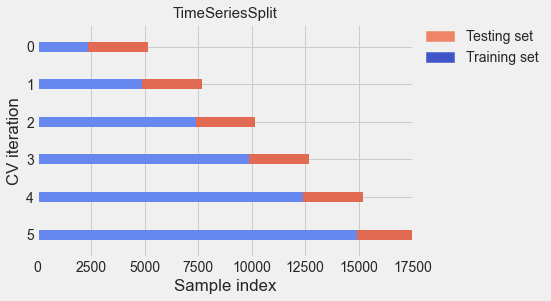

In [20]:
# plotting with a simple array data
n_split = 6
tscv = TimeSeriesSplit(n_splits=n_split)

print(tscv)
for train, test in tscv.split(raw_df):
    print("%s %s" % (train, test))
    
    
    
    
plot_cv_indices(tscv, raw_df, n_splits=n_split)

LR: -6162.189530 (2703.027411)
NN: -5846.172051 (2949.639772)
KNN: -5259.658609 (3089.241714)
RF: -2352.042909 (1329.099836)
SVR: -33621.497666 (19855.194532)


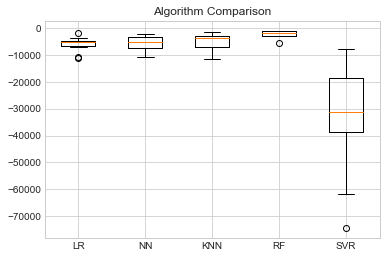

In [17]:
from sklearn.linear_model import LinearRegression 
from sklearn.neural_network import MLPRegressor 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.svm import SVR 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import r2_score 

# Spot Check Algorithms 
models = [] 
models.append(('LR', LinearRegression())) 
models.append(('NN', MLPRegressor(solver = 'lbfgs'))) #neural network 
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) 
# Ensemble method - collection of many decision trees 
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear 
# Evaluate each model in turn 
results = [] 
names = [] 
for name, model in models: 
    # TimeSeries Cross validation 
    tscv = TimeSeriesSplit(n_splits=10) 
    
    # score = 'neg_mean_squared_error'
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
    results.append(cv_results) 
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())) 
    
# Compare Algorithms 
plt.boxplot(results, labels=names) 
plt.title('Algorithm Comparison') 
plt.show()

In [ ]:
https://gmnam.tistory.com/235?category=942032

### 블럭 교차 검증

In [16]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
        
    def get_n_splits(self, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
        
        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

[   0    1    2 ... 2336 2337 2338] [2339 2340 2341 2342 2343 2344 2345 2346 2347 2348 2349 2350 2351 2352
 2353 2354 2355 2356 2357 2358 2359 2360 2361 2362 2363 2364 2365 2366
 2367 2368 2369 2370 2371 2372 2373 2374 2375 2376 2377 2378 2379 2380
 2381 2382 2383 2384 2385 2386 2387 2388 2389 2390 2391 2392 2393 2394
 2395 2396 2397 2398 2399 2400 2401 2402 2403 2404 2405 2406 2407 2408
 2409 2410 2411 2412 2413 2414 2415 2416 2417 2418 2419 2420 2421 2422
 2423 2424 2425 2426 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436
 2437 2438 2439 2440 2441 2442 2443 2444 2445 2446 2447 2448 2449 2450
 2451 2452 2453 2454 2455 2456 2457 2458 2459 2460 2461 2462 2463 2464
 2465 2466 2467 2468 2469 2470 2471 2472 2473 2474 2475 2476 2477 2478
 2479 2480 2481 2482 2483 2484 2485 2486 2487 2488 2489 2490 2491 2492
 2493 2494 2495 2496 2497 2498 2499 2500 2501 2502 2503 2504 2505 2506
 2507 2508 2509 2510 2511 2512 2513 2514 2515 2516 2517 2518 2519 2520
 2521 2522 2523 2524 2525 2526 2527 2528 

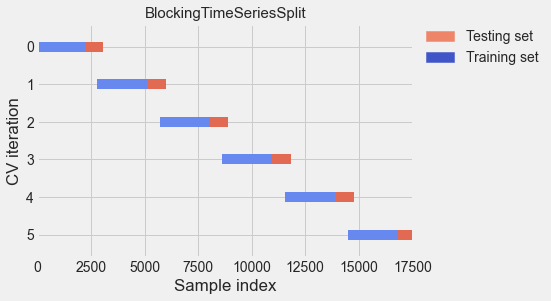

In [21]:
n_split = 6
btscv = BlockingTimeSeriesSplit(n_splits=n_split)

for train, test in btscv.split(raw_df):
    print("%s %s" % (train, test))

plot_cv_indices(btscv, raw_df, n_splits=n_split)

In [ ]:
# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs', max_iter=2000)))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) 
# Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # blocked Cross-validation
    btscv = BlockingTimeSeriesSplit(n_splits=10)
    
    cv_results = cross_val_score(model, X_train, y_train, cv=btscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison (blocked CV)')
plt.show()


출처: https://gmnam.tistory.com/235?category=942032 [Voyager]

## 범주 데이터 수치화

### get_dummies

In [ ]:
col_list = []

col_ohe = pd.get_dummies(X_train[col_list])

X_train_ohe = pd.concat([X_train, col_ohe], axis=1)
X_train = X_train_ohe.drop(col_list, axis=1)

### Label Incoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

col_list=['TV','냉장고','전자렌지','컴퓨터','선풍기','선풍기','믹서','믹서']

# LabelEncoder를 객체로 생성한 후 , fit( ) 과 transform( ) 으로 label 인코딩 수행. 
encoder = LabelEncoder()
encoder.fit(col_list)
labels = encoder.transform(col_list)
print('인코딩 변환값:',labels)

In [ ]:
print('인코딩 클래스:',encoder.classes_)

In [ ]:
print('디코딩 원본 값:',encoder.inverse_transform([4, 5, 2, 0, 1, 1, 3, 3]))

### one-hot Incoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

col_list=['TV','냉장고','전자렌지','컴퓨터','선풍기','선풍기','믹서','믹서']

# 먼저 숫자값으로 변환을 위해 LabelEncoder로 변환합니다. 
encoder = LabelEncoder()
encoder.fit(col_list)
labels = encoder.transform(col_list)

# 2차원 데이터로 변환합니다. 
labels = labels.reshape(-1,1)

# 원-핫 인코딩을 적용합니다. 
oh_encoder = OneHotEncoder()
oh_encoder.fit(labels)
oh_labels = oh_encoder.transform(labels)

print('원-핫 인코딩 데이터')
print(oh_labels.toarray())
print('원-핫 인코딩 데이터 차원')
print(oh_labels.shape)

## Scaler

### StandardScaler

In [22]:
# X_features scaling
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train_S = pd.DataFrame(scaler.transform(X_train), 
                                       index=X_train.index, columns=X_train.columns)
X_test_S = pd.DataFrame(scaler.transform(X_test), 
                           index=X_test.index, columns=X_test.columns)
display(X_test_S.describe().T)

# y_target scaling
scaler = StandardScaler()
scaler = scaler.fit(y_train)
y_train_S = pd.DataFrame(scaler.transform(y_train), 
                                       index=y_train.index, columns=y_train.columns)
y_test_S = pd.DataFrame(scaler.transform(y_test), 
                           index=y_test.index, columns=y_test.columns)
display(y_test_S.describe().T)

,count,mean,std,min,25%,50%,75%,max
season,4416.0,1.100525,0.729351,-1.143598,0.754878,0.754878,1.704117,1.704117
holiday,4416.0,0.022815,1.062220,-0.172183,-0.172183,-0.172183,-0.172183,5.807767
...,...,...,...,...,...,...,...,...
Quater_Dummy_3,4416.0,0.887109,1.336925,-0.449664,-0.449664,0.887109,2.223882,2.223882
Quater_Dummy_4,4416.0,0.887109,1.336925,-0.449664,-0.449664,0.887109,2.223882,2.223882


,count,mean,std,min,25%,50%,75%,max
count,4416.0,0.533538,1.367566,-1.027714,-0.699568,0.28487,1.292637,5.043767


### MinMaxScaler

In [62]:
# X_features scaling
scaler = MinMaxScaler()
scaler = scaler.fit(X_train)
X_train_S = pd.DataFrame(scaler.transform(X_train), 
                                       index=X_train.index, columns=X_train.columns)
X_test_S = pd.DataFrame(scaler.transform(X_test), 
                           index=X_test.index, columns=X_test.columns)
display(X_test_S.describe().T)

# y_target scaling
scaler = MinMaxScaler()
scaler = scaler.fit(y_train)
y_train_S = pd.DataFrame(scaler.transform(y_train), 
                                       index=y_train.index, columns=y_train.columns)
y_test_S = pd.DataFrame(scaler.transform(y_test), 
                           index=y_test.index, columns=y_test.columns)
display(y_test_S.describe().T)

,count,mean,std,min,25%,50%,75%,max
season,4416.0,0.788043,0.256118,0.0,0.666667,0.666667,1.0,1.0
holiday,4416.0,0.032609,0.177630,0.0,0.000000,0.000000,0.0,1.0
...,...,...,...,...,...,...,...,...
Quater_Dummy_3,4416.0,0.500000,0.500057,0.0,0.000000,0.500000,1.0,1.0
Quater_Dummy_4,4416.0,0.500000,0.500057,0.0,0.000000,0.500000,1.0,1.0


,count,mean,std,min,25%,50%,75%,max
count,4416.0,0.262525,0.229956,0.0,0.055178,0.220711,0.390167,1.020921


In [57]:
y_train

,count
DateTime,
2011-01-01 00:00:00,16
2011-01-01 01:00:00,40
...,...
2012-06-30 22:00:00,172
2012-06-30 23:00:00,152


### Normalizer

In [ ]:
# X_features scaling
scaler = Normalizer()
scaler = scaler.fit(X_train)
X_train_S = pd.DataFrame(scaler.transform(X_train), 
                                       index=X_train.index, columns=X_train.columns)
X_test_S = pd.DataFrame(scaler.transform(X_test), 
                           index=X_test.index, columns=X_test.columns)
display(X_test_S.describe().T)

# y_target scaling
scaler = Normalizer()
scaler = scaler.fit(y_train)
y_train_S = pd.DataFrame(scaler.transform(y_train), 
                                       index=y_train.index, columns=y_train.columns)
y_test_S = pd.DataFrame(scaler.transform(y_test), 
                           index=y_test.index, columns=y_test.columns)
display(y_test_S.describe().T)

### Log1p

In [11]:
# X_features scaling
X_train_S = pd.DataFrame(np.log1p(X_train), index=X_train.index, columns=X_train.columns)
X_test_S = pd.DataFrame(np.log1p(X_test), index=X_test.index, columns=X_test.columns)
display(X_test_S.describe().T)

# y_target scaling
y_train_S = pd.DataFrame(np.log1p(y_train), index=X_train.index, columns=y_train.columns)
y_test_S = pd.DataFrame(np.log1p(y_test), index=y_test.index, columns=y_test.columns)
display(y_test_S.describe().T)

,count,mean,std,min,25%,50%,75%,max
season,4416.0,1.452790,0.219993,0.693147,1.386294,1.386294,1.609438,1.609438
holiday,4416.0,0.022603,0.123124,0.000000,0.000000,0.000000,0.000000,0.693147
...,...,...,...,...,...,...,...,...
Quater_Dummy_3,4416.0,0.346574,0.346613,0.000000,0.000000,0.346574,0.693147,0.693147
Quater_Dummy_4,4416.0,0.346574,0.346613,0.000000,0.000000,0.346574,0.693147,0.693147


,count,mean,std,min,25%,50%,75%,max
count,4416.0,4.900893,1.396671,0.693147,4.002746,5.361292,5.926926,6.88551


## 다중공선성제거

### VIF
  - Vif factor는 X와 X관의 관계를 나타내는 것으로 높을 수록 안 좋다.
  - 상관관계가 높은 컬럼들하고 겹치는 것들을 우선 사용한다.
  - 해당 변수가 다른 변수와 전혀 상관 관계가 없다면 VIF = 1이고, 해당 변수의 R-squared 값은 0이다.
  - 10 이상이면 서로 강한 상관관계를 보이는 것이라고 함
  - 1 에서 10 미만의 값이면 다중공선성이 별 문제가 되지 않는 것으로 판단한다
  - VIFk = 1 / (1 - Rj2)
    -  결정계수 Rj2 값이 0에 가깝다는 것은 입력변수 k가 다른 입력변수들과 상관성이 거의 없다는 것을 의미하고,
    - 결정계수 Rj2 값이 1에 가깝다는 것은 입력변수 k가 다른 입력변수들과 상관성, 즉 다중공선성이 크다는 것을 의미한다.

#### 상관도 확인

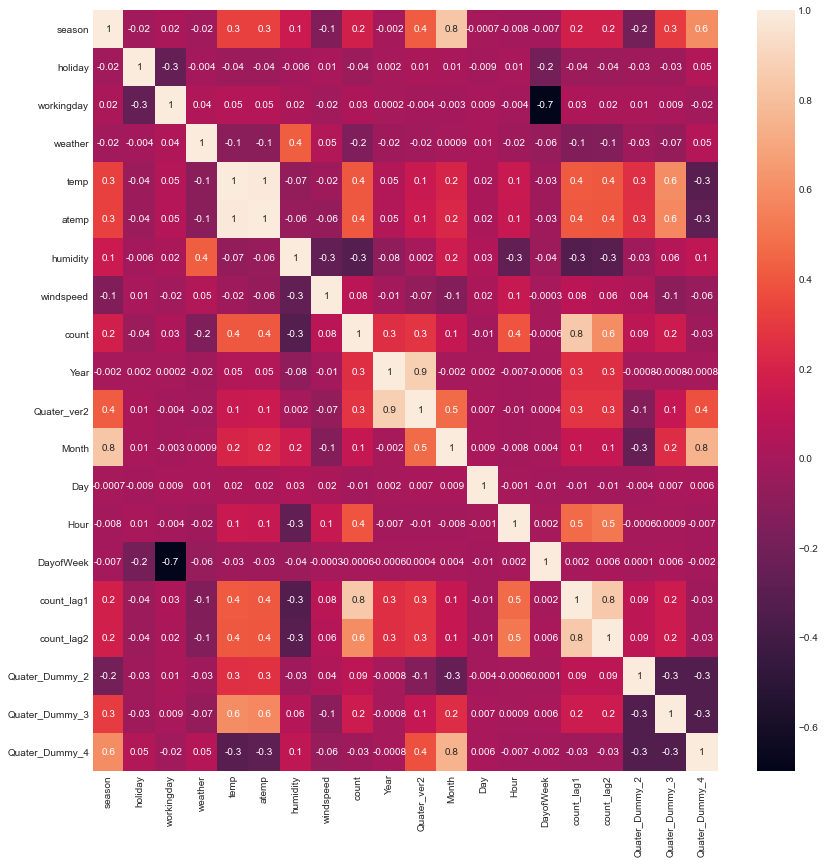

In [12]:
corr = X_features.corr()
plt.figure(figsize=(14,14))
sns.heatmap(corr, annot=True, fmt='.1g')

In [13]:
# correlation from features
raw_df.corr().loc[X_colname, X_colname].style.background_gradient().set_precision(2).set_properties(**{'font-size': '11pt'})

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Year,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
season,1.00,-0.02,0.02,-0.02,0.32,0.33,0.15,-0.14,-0.00,0.42,0.83,-0.00,-0.01,-0.01,0.18,0.18,-0.20,0.31,0.60
holiday,-0.02,1.00,-0.26,-0.00,-0.04,-0.04,-0.01,0.01,0.00,0.01,0.01,-0.01,0.01,-0.19,-0.04,-0.04,-0.03,-0.03,0.05
workingday,0.02,-0.26,1.00,0.04,0.05,0.05,0.02,-0.02,0.00,-0.00,-0.00,0.01,-0.00,-0.70,0.03,0.02,0.01,0.01,-0.02
weather,-0.02,-0.00,0.04,1.00,-0.11,-0.11,0.43,0.05,-0.02,-0.02,0.00,0.01,-0.02,-0.06,-0.14,-0.14,-0.03,-0.07,0.05
temp,0.32,-0.04,0.05,-0.11,1.00,0.99,-0.07,-0.02,0.05,0.14,0.21,0.02,0.14,-0.03,0.41,0.40,0.26,0.60,-0.31
atemp,0.33,-0.04,0.05,-0.11,0.99,1.00,-0.06,-0.06,0.05,0.15,0.22,0.02,0.13,-0.03,0.41,0.40,0.27,0.58,-0.29
humidity,0.15,-0.01,0.02,0.43,-0.07,-0.06,1.00,-0.27,-0.08,0.00,0.16,0.03,-0.27,-0.04,-0.33,-0.31,-0.03,0.06,0.10
windspeed,-0.14,0.01,-0.02,0.05,-0.02,-0.06,-0.27,1.00,-0.01,-0.07,-0.13,0.02,0.14,-0.00,0.08,0.06,0.04,-0.10,-0.06
Year,-0.00,0.00,0.00,-0.02,0.05,0.05,-0.08,-0.01,1.00,0.87,-0.00,0.00,-0.01,-0.00,0.25,0.25,-0.00,-0.00,-0.00
Quater_ver2,0.42,0.01,-0.00,-0.02,0.14,0.15,0.00,-0.07,0.87,1.00,0.47,0.01,-0.01,0.00,0.28,0.28,-0.13,0.12,0.38


In [14]:
corr = X_features.corr().loc[:, ['count']]

In [15]:
corr = X_features.corr().loc[:, ['count']].style.background_gradient().set_precision(2).set_properties(**{'font-size': '11pt'})

In [16]:
corr

,count
season,0.18
holiday,-0.04
workingday,0.03
weather,-0.15
temp,0.41
atemp,0.41
humidity,-0.33
windspeed,0.08
count,1.00
Year,0.25


In [28]:
raw_df.describe()

,season,holiday,workingday,weather,temp,...,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
count,17544....,17544....,17544....,17544....,17544....,...,17544....,17544....,17544....,17544....,17544....
mean,2.49658,0.029754,0.682969,1.434223,20.303413,...,187.79...,187.79...,0.248974,0.25171,0.25171
...,...,...,...,...,...,...,...,...,...,...,...
75%,3.00000,0.000000,1.000000,2.000000,27.060000,...,279.00...,279.00...,0.000000,1.00000,1.00000
max,4.00000,1.000000,1.000000,4.000000,41.000000,...,977.00...,977.00...,1.000000,1.00000,1.00000


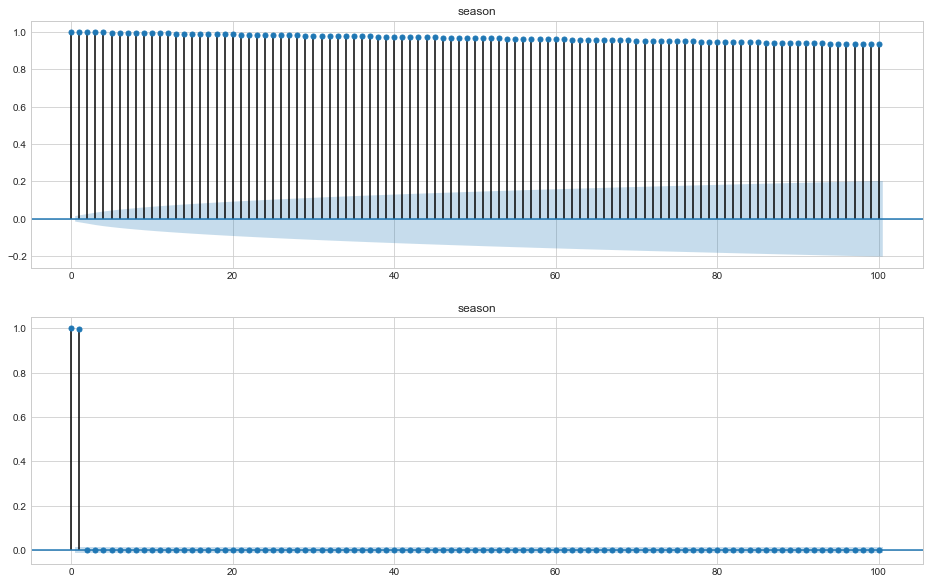

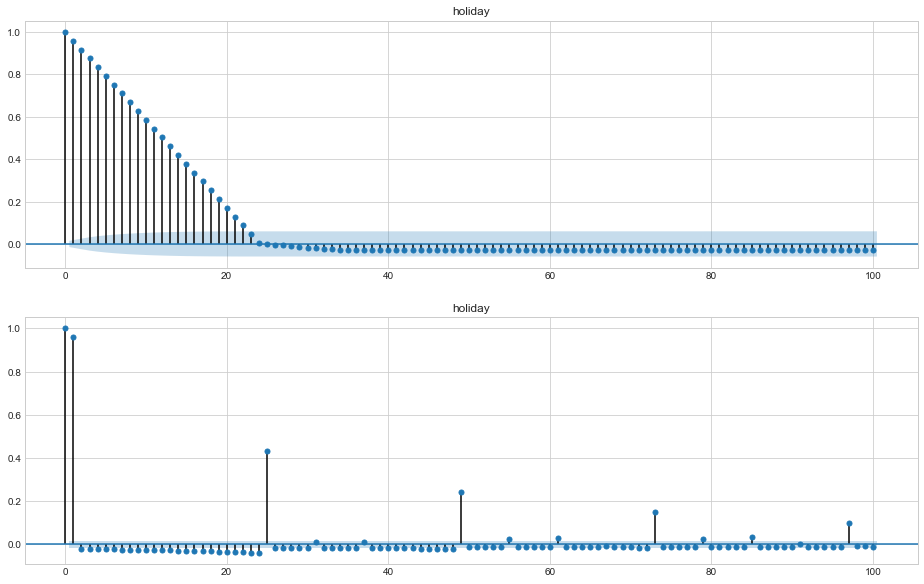

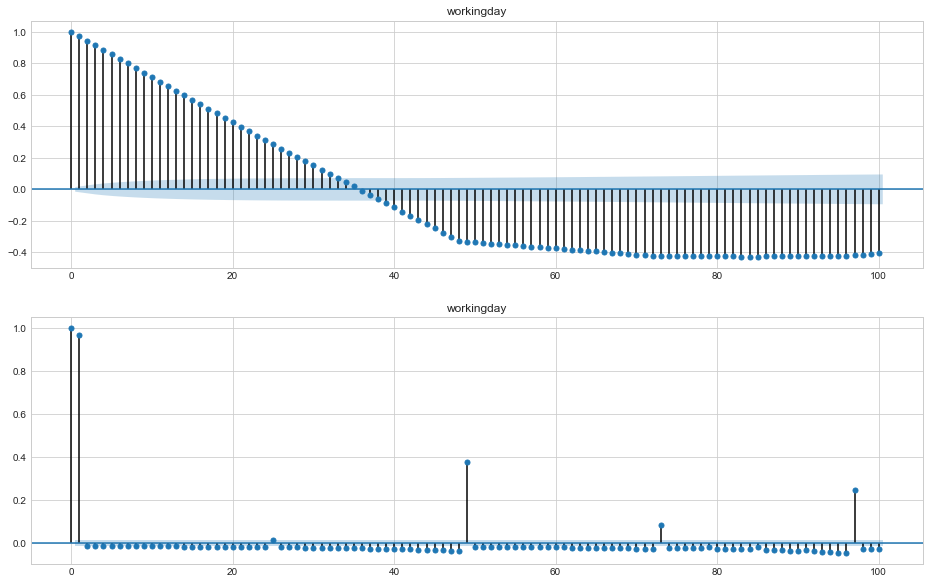

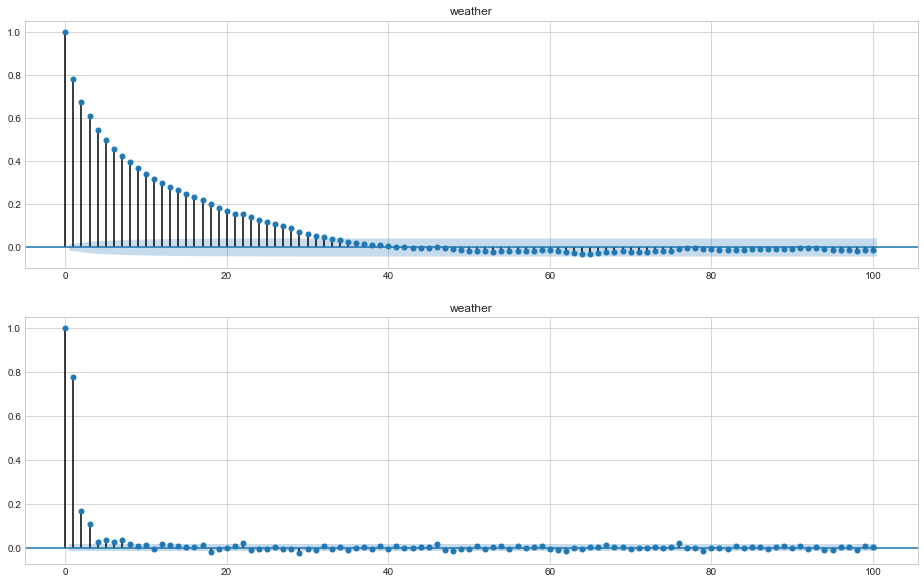

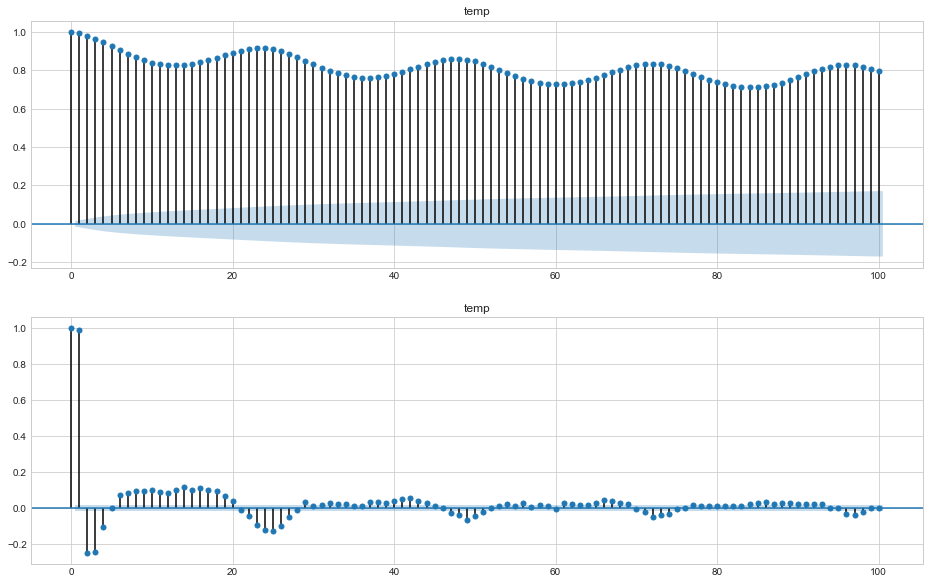

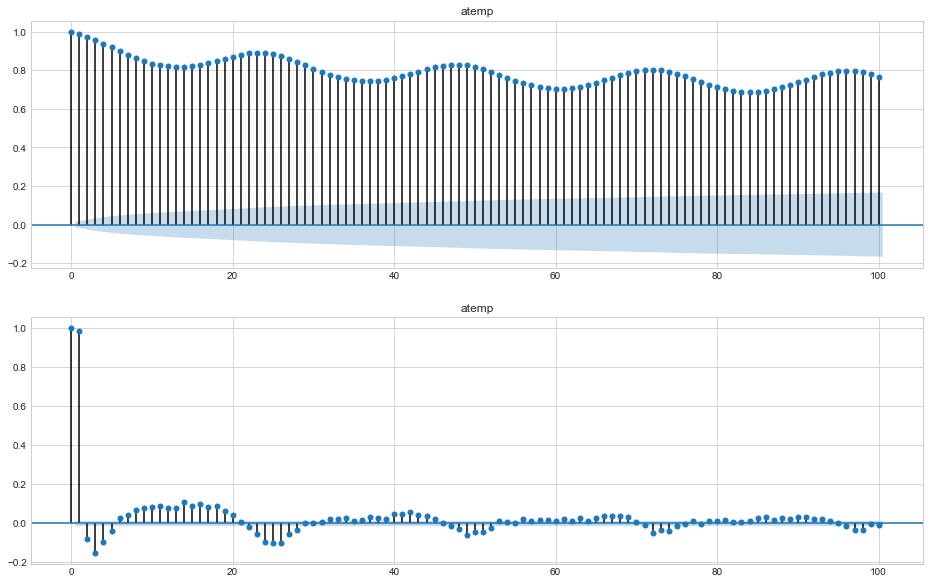

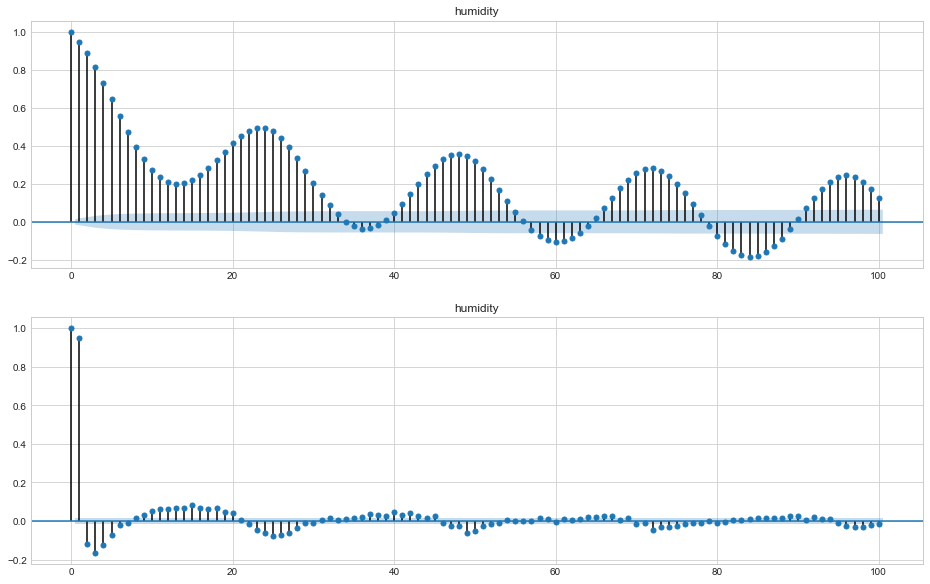

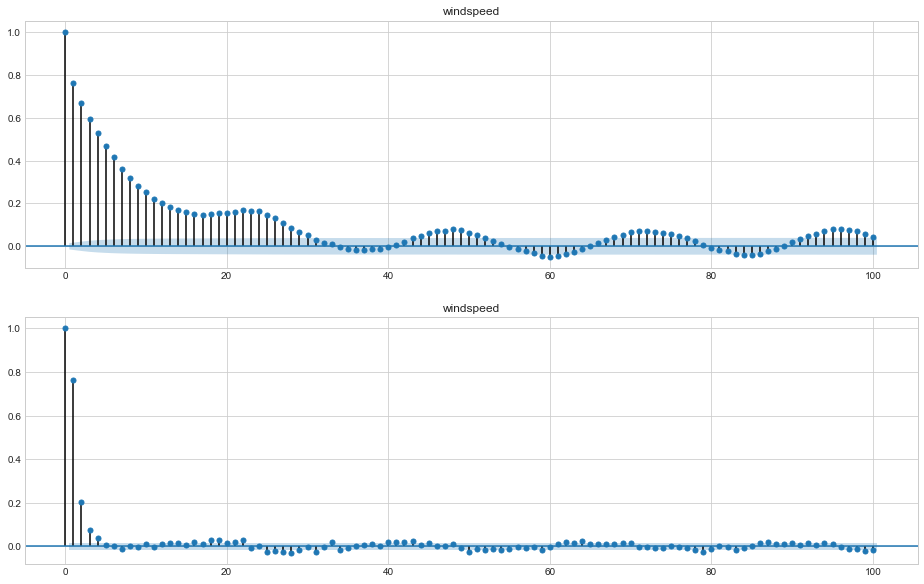

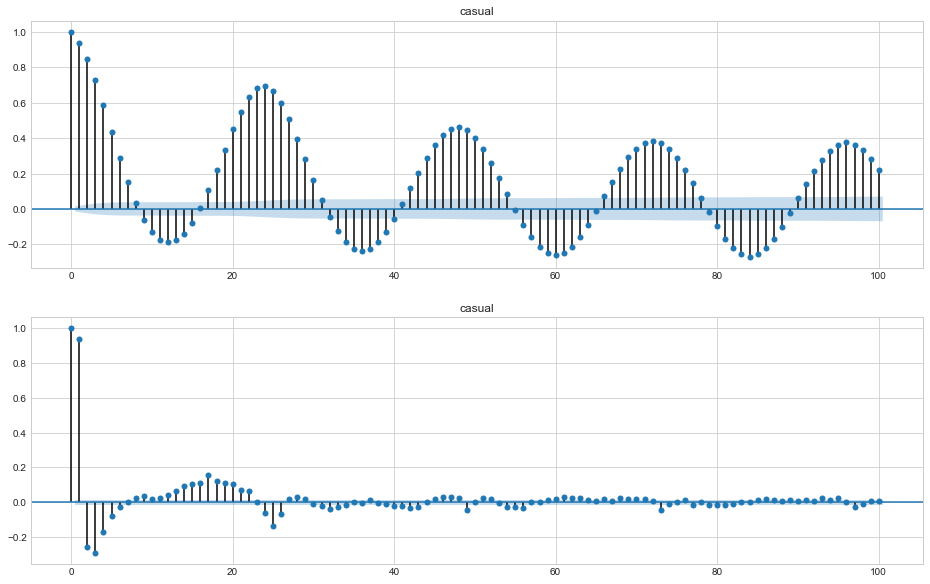

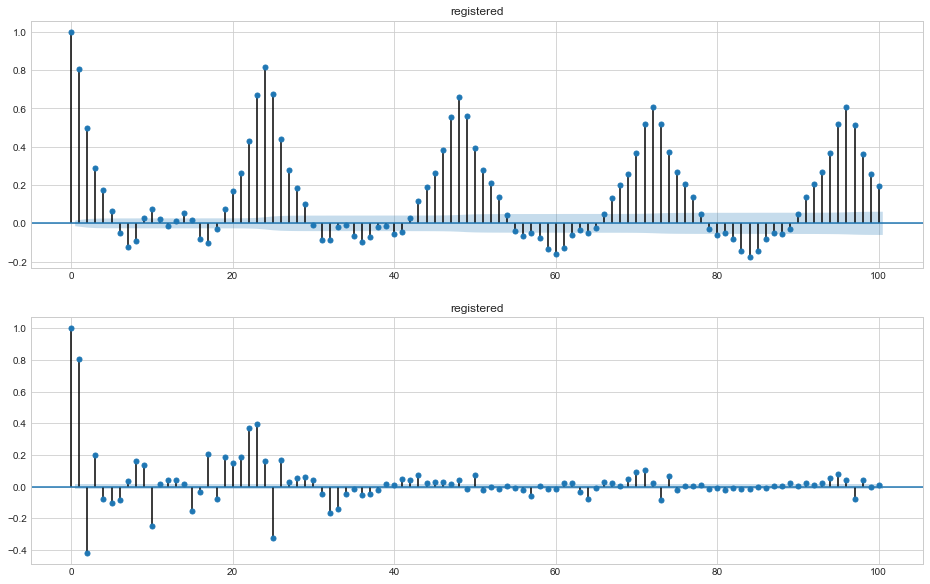

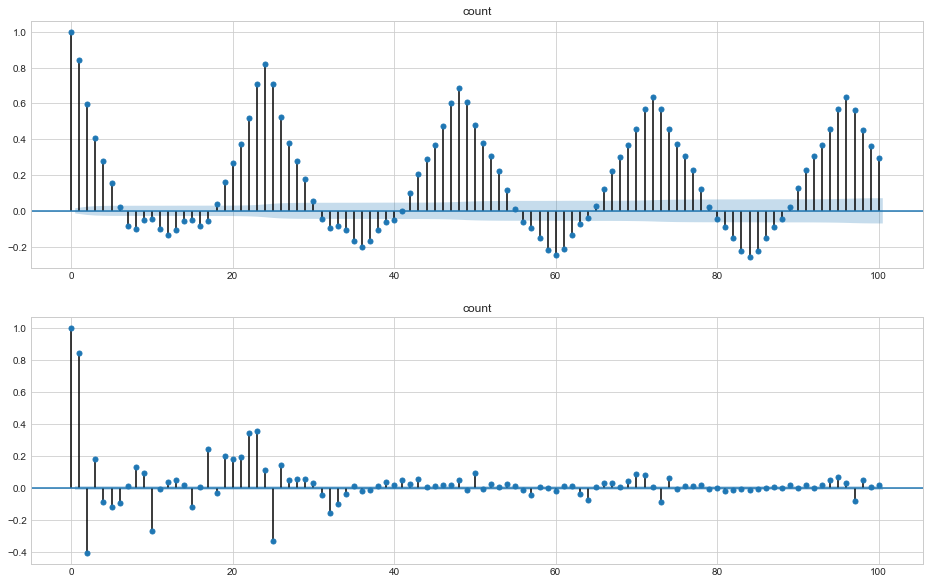

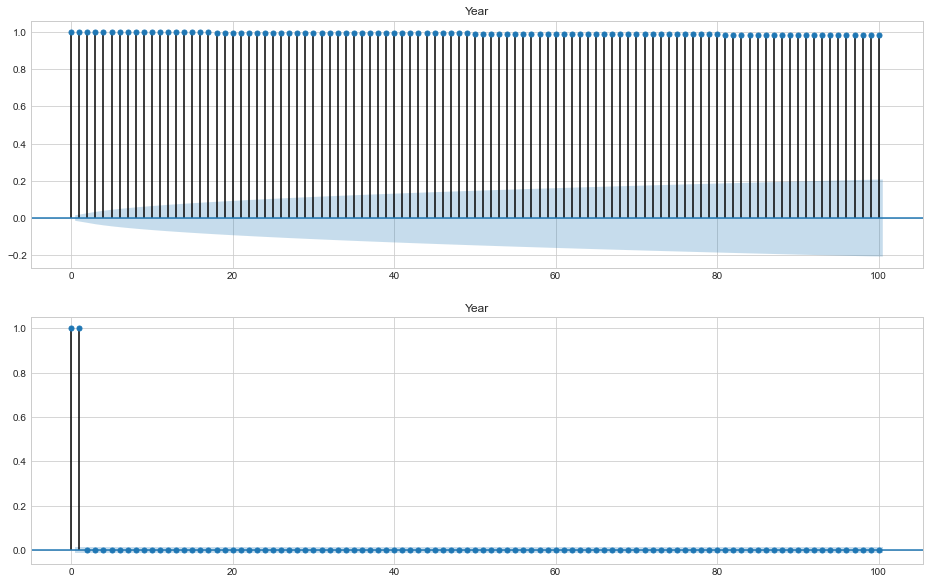

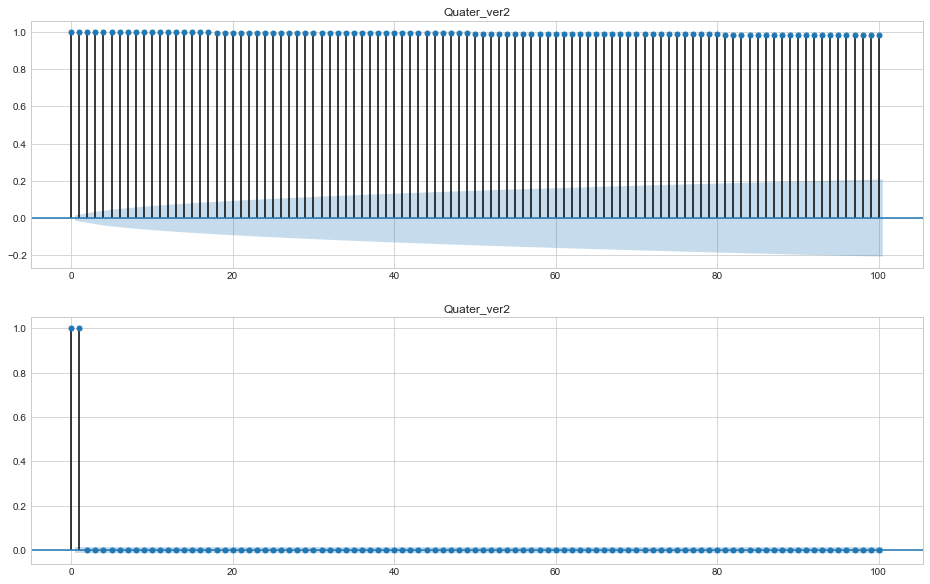

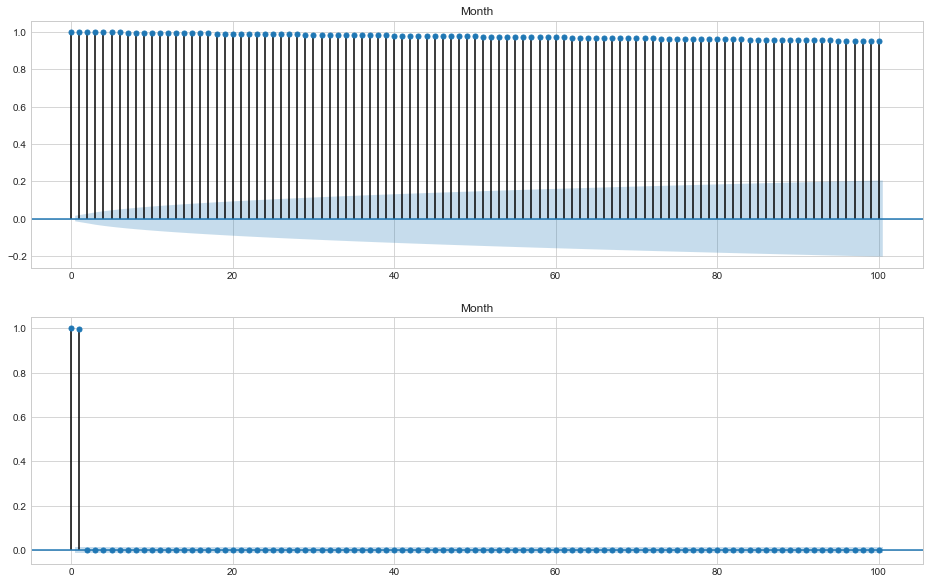

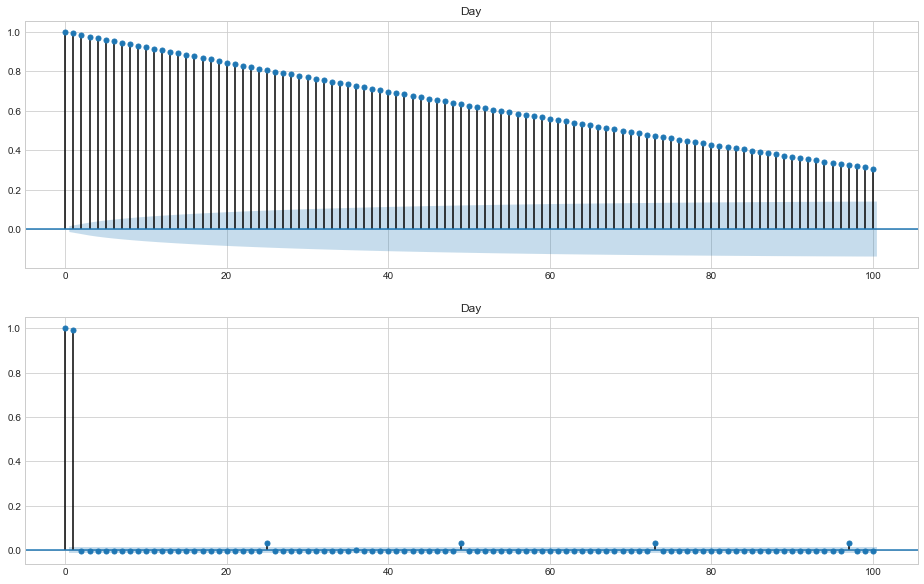

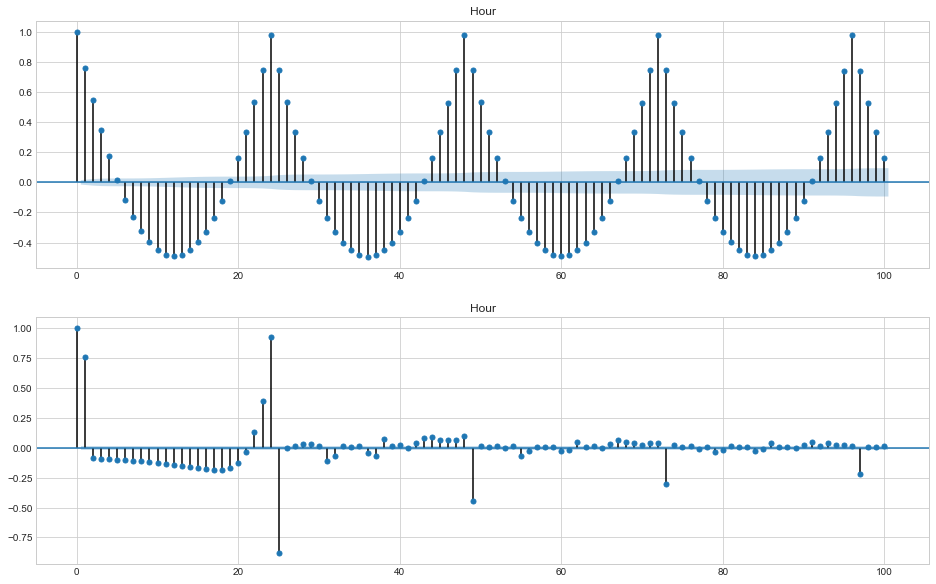

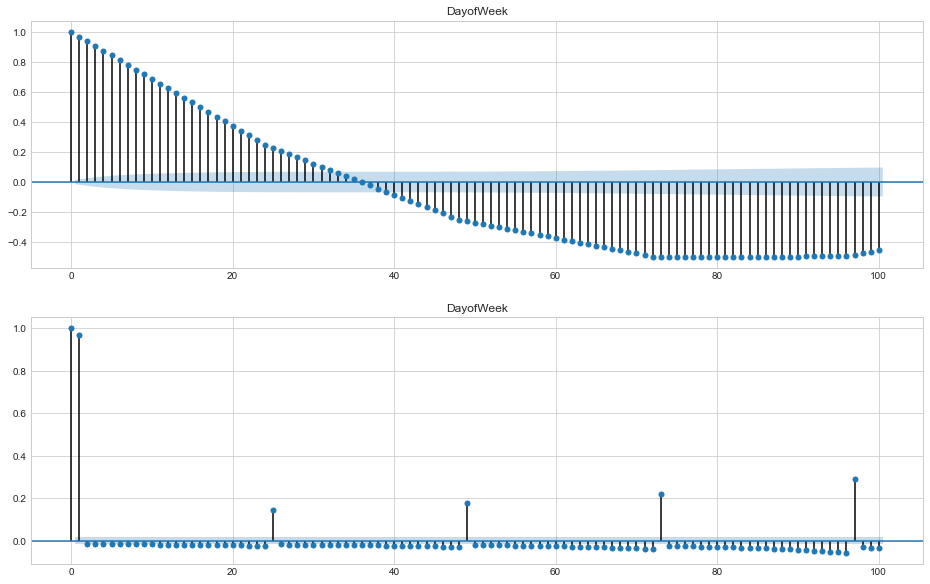

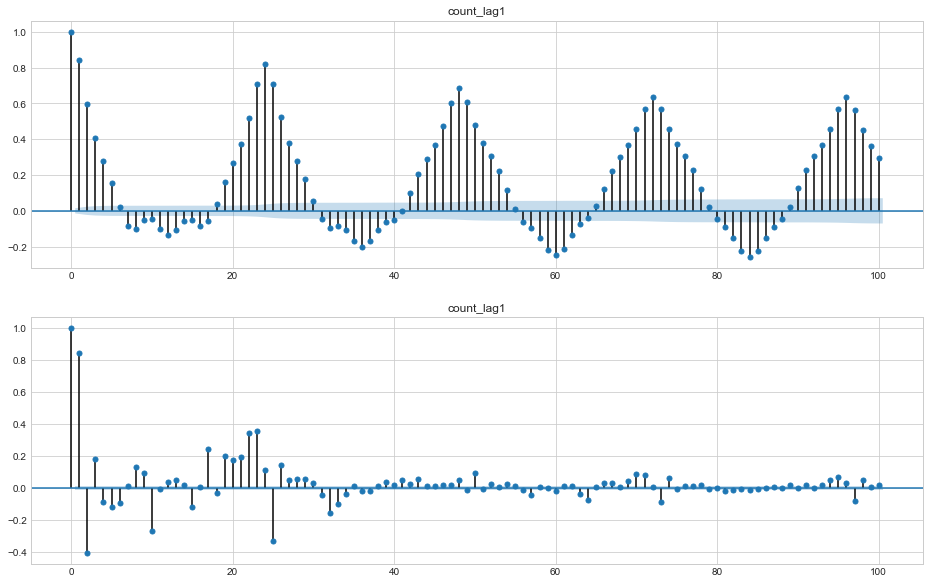

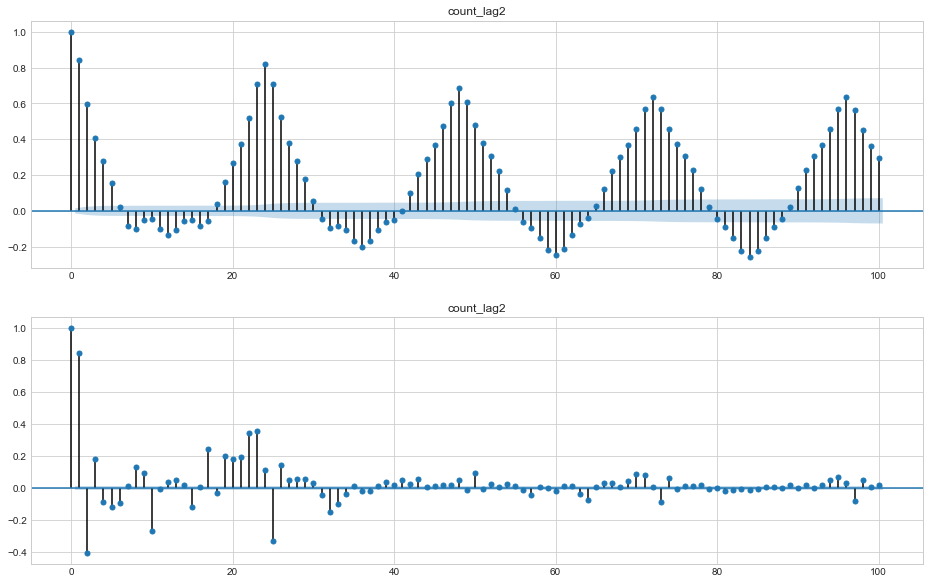

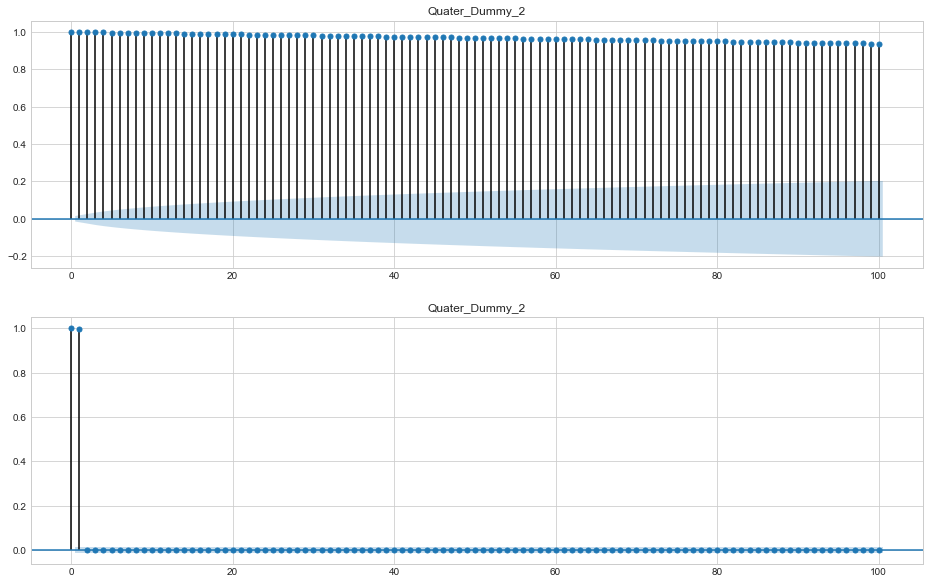

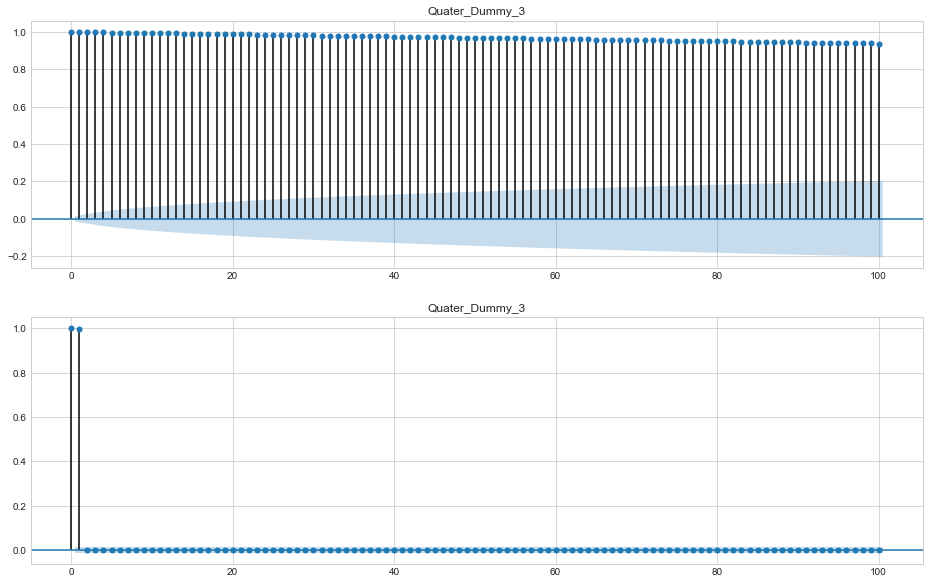

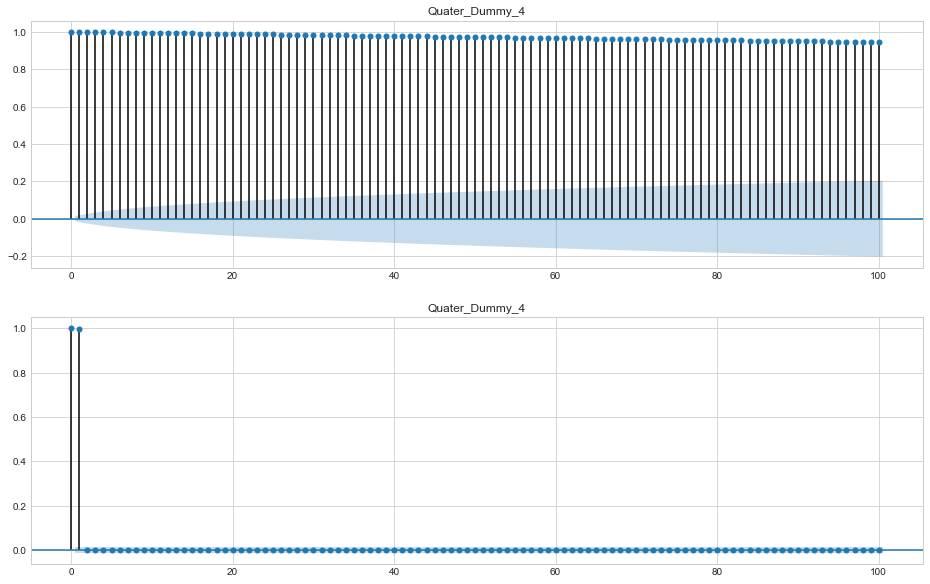

In [46]:
for col in raw_df.describe().columns:
    target = raw_df[col]
    figure, axes = plt.subplots(2,1,figsize=(16,10))
    sm.graphics.tsa.plot_acf(target, lags=100, use_vlines=True, ax=axes[0], title=col)
    sm.graphics.tsa.plot_pacf(target, lags=100, use_vlines=True, ax=axes[1], title=col)  

In [17]:
vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(X_train_S.values, i) 
                     for i in range(X_train_S.shape[1])]
vif['Feature'] = X_train_S.columns
vif.sort_values(by='VIF_Factor', ascending=True)

,VIF_Factor,Feature
1,1.447335,holiday
2,5.856819,workin...
...,...,...
4,2109.1...,temp
5,2404.8...,atemp


In [18]:
# extract effective features using variance inflation factor
vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(X_train_S.values, i) 
                     for i in range(X_train_S.shape[1])]
vif['Feature'] = X_train_S.columns
vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:10].values

array(['holiday', 'workingday', 'Quater_Dummy_2', 'DayofWeek',
       'windspeed', 'Quater_Dummy_3', 'Hour', 'Day', 'Quater_ver2',
       'Quater_Dummy_4'], dtype=object)

#### 독립변수 일부 반영

In [9]:
### Functionalize
### extract non-multicollinearity variables by VIF 
def feature_engineering_XbyVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values
    return X_colname_vif
# X_colname_vif = feature_engineer

In [11]:
feature_engineering_XbyVIF(X_train, 8)

array(['Day', 'windspeed', 'weather', 'Hour', 'holiday', 'humidity',
       'DayofWeek', 'workingday'], dtype=object)

### PCA

In [85]:
pca = PCA(n_components=2)

#fit( )과 transform( ) 을 호출하여 PCA 변환 데이터 반환
pca.fit(X_features)
X_features_pca = pca.transform(X_features)

print('PCA Component별 변동성:', pca.explained_variance_ratio_)

PCA Component별 변동성: [0.83834747 0.1330986 ]


### LDA

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
# fit()호출 시 target값 입력 
lda.fit(X_features, y_target)
X_features_lda = lda.transform(X_features)
print(iris_lda.shape)

In [ ]:
lda_columns=['lda_component_1','lda_component_2']
X_lda_df = pd.DataFrame(X_features_lda,columns=lda_columns)
X_lda_df['target']=y_target

### SVD(미완)

### Truncated SVD(미완)

### NMF(미완)

## 정상성 테스트

### 정상성 확인(ARIMA에서 차분 실행 / SARIMA에서 트랜드, 계절성 차분 실행
* 차분/로그변환/계절성제거 등을 통해 데이터를 정상성 형태로 변환

Test Statistics     -6.8416...
p-value              1.7850...
Used Lag             4.1000...
Used Observations    1.3086...
dtype: float64

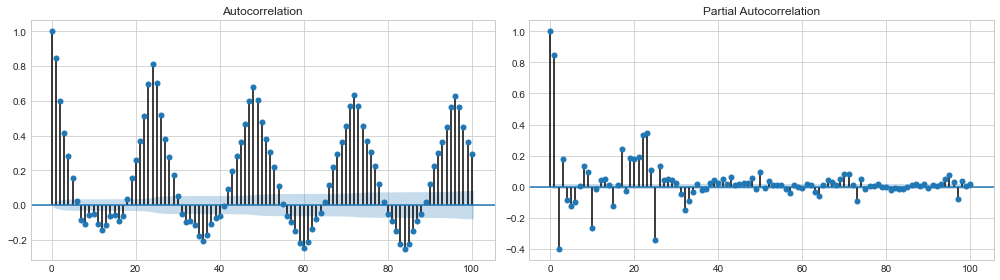

In [21]:
## 정상성 테스트 및 모수추론(p=1, q=1, d=0, P=1, Q=1, D(m)=12)
result = pd.Series(sm.tsa.stattools.adfuller(y_train.values.flatten())[0:4],
                   index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
display(result)

plt.figure(figsize=(14,4))
sm.tsa.graphics.plot_acf(y_train, lags=100, alpha=0.05, use_vlines=True, ax=plt.subplot(121))
sm.tsa.graphics.plot_pacf(y_train, lags=100, alpha=0.05, use_vlines=True, ax=plt.subplot(122))
plt.tight_layout()
plt.show()

### 정상성 확보

In [37]:
y_train

,count
DateTime,
2011-01-01 00:00:00,16
2011-01-01 01:00:00,40
...,...
2012-06-30 22:00:00,172
2012-06-30 23:00:00,152


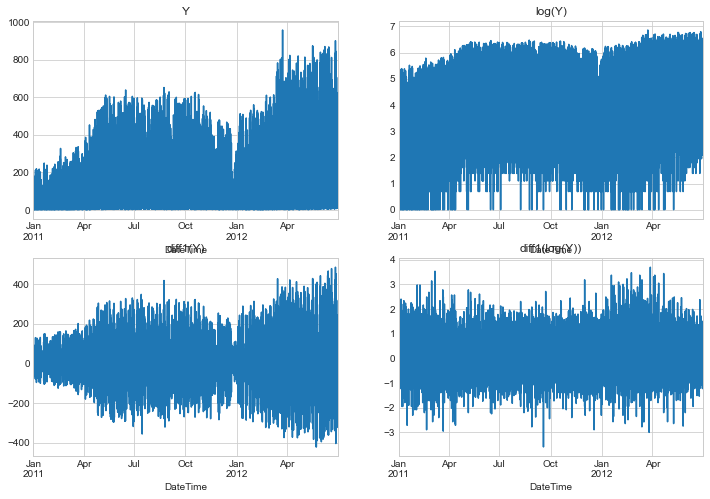

In [25]:
## 정상성 확보
plt.figure(figsize=(12,8))
y_train.plot(ax=plt.subplot(221), title='Y', legend=False)
np.log(y_train).plot(ax=plt.subplot(222), title='log(Y)', legend=False)
y_train.diff(1).plot(ax=plt.subplot(223), title='diff1(Y)', legend=False)
np.log(y_train).diff(1).plot(ax=plt.subplot(224), title='diff1(log(Y))', legend=False)
plt.show()

# 분석 및 평가

## 함수

In [21]:
### Functionalize
### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)

In [22]:
# Error Analysis: 분석모형이 데이터패턴을 모두 추출하여 분석을 종료해도 되는지 판단하기

### Functionalize
### Error analysis
def stationarity_adf_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf

def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss

## Y예측을 위한 Base분석 실행
상단
* Model : 
* Method : 
* ***R-squared : 높을 수록 좋음.*** 사회과학에서는 보통 0.4 이상 이면 괜찮은 모델이라고 봄
  - 데이터에 잘 적합된 정도, 모델에 의해 설명되는 데이터 분산의 정도(퍼센트)
* ***Adj. R-squared*** : 독립변수의 개수와 표본의 크기를 고려하여 R-squared를 보정
  - 독립변수가 여러 개인 다중회귀분석에서 사용
  - 서로 다른 모형을 비교할 때는 이 지표가 높은 쪽은 선택한다
* ***F-statistic*** : F-test의 검정통계량으로 변수들 전체의 유의성을 체크함 
* ***Prob (F-statistic) : F-검정의 p-value로 p-value < 0.05 이여야 함***
* ***Log-likelihood : 우도는 높을수록 좋음. 우도의 값은 확률임(0 < 확률 < 1)***
  - 회귀모델이 실제값이랑 잘 맞으면 우도가 높아짐
  - 종속변수가 정규분포라 가정했을 때 그 우도
  - 로그우도도 R제곱과 마찬가지로 독립변수가 많아지면 증가한다
  - 모델과 추정치가 데이터와 잘 맞는 정도를 확률로 표현한 것
  - 확률은 모델과 추정치가 원인이고 데이터가 결과이다.(모델과 추정치에 의해 이러한 데이터가 나올 확률/데이터에 대한 확률)
  - 우도는 데이터가 원인이고 모델과 추정치는 결과이다.(데이터에 의해 이러한 모델과 추정치가 나올 우도/ 모델과 추정치에 대한 우도)
  - 최대우도법 : 데이터에 제일 잘 맞는 모델과 추정치를 계산하는 방법
  - 최우추정치 : 데이터에 제일 잘 맞는 추정치
* ***AIC : 낮을수록 좋음. -2log(우도) + 2P***
* ***BIC : 낮을수록 좋음. -2log(우도) + plog(n)***
  - -2log(우도) = Deviance
  - 로그우도를 독립변수의 수로 보정한 값
  - 높을수록 안좋음. 어떤 모형이 가장 적절하냐를 판단할때 사용
  - 표준오차랑 비슷한 것
  - 계산하기 위해서는 우도를 알아야 함 / -2log(우도) + (something more)
  - -2를 곱한건 통계적인 이유가 있음
  - log를 씌운것은 값이 너무 작아서 그걸 우리가 보기 편하게 하기 위해서임
* ***No. Observations : 해당 개수의 데이터 쌍을 가지고 회귀분석을 실시하였다는 것을 알 수 있다.***
* ***Df Model : 회귀분석 전체 파라미터 숫자 - 1.*** 회귀분석의 "예측변수의 숫자(k)"를 의미
  - 회귀분석의 전체 파라미터는 1개의 종속변수를 포함하므로 Df Model은 다른 식으로는 "회귀분석 전체 파라미터 숫자 - 1" 이다
* ***Df Residuals : Df Residuals는 "No.observations - (Df Model + 1)"로 산출***
  - 전체 관찰데이터의 수에서 회귀모형의 전체 파라미터의 수를 뺀 값
  
  
하단
* Omnibus : 
* Prob(Omnibus) :
* ***Durbin-Watson : 중간이 좋음. 자기상관 테스트(잔차의 독립성)로 p-value >= 0.05 이여야 함***
  - ***보통 1.5 ~ 2.5사이이면 독립으로 판단하고 회귀모형이 적합하다는 것을 의미***
  - 0이면 잔차들이 양의 자기상관을 갖고, 2이면 자기상관이 없는 독립성을 갖고, 4이면 잔차들이 음의 자기상관을 갖는다고 해석
  - ***DW검정값이 0 또는 4에 가깝다는 것은 잔차들이 자기상관을 가지고 있다는 의미***이고, 이는 t값, F값, R제곱을 실제보다 증가시켜 실제로 유의미하지 않은 결과를 유의미한 결과로 왜곡하게 된다.
* ***Jaque-Bera (JB) : 0에서 멀리 떨어진 값이 나오면, 그때는 정규분포(normal distribution)에 적합하지 않다고 판정***
  - 정규분포 테스트의 검정통계량
  - JB = (n/6) * (S²+ (C²/4) : n:관찰된 표본 수, S:표본의 왜도(skewness), C:표본의 첨도(kurtosis)
  
* ***Prob(JB) : Jaque_Bera의 유의수준으로 p-value >= 0.05 이여야 함***
* ***Skew : 왜도(중심에서 기울어진 정도) / 절대값 3 미만 기준에 부합 / -2~2 치우침은 왜도가 크지 않다고 판단***
* ***Kutosis : 첨도(뾰족한 정도) / 절대값 7 미만 기준에 부합 / 첨도가 크면 이상치가 많음, ***
* ***Cond. No. :  공분산행렬  (XT)X 의 조건수가 크면 회귀분석을 사용한 예측값도 오차가 커진다.***
  - 조건수(conditional number)는 가장 큰 고유치와 가장 작은 고유치의 비율을 뜻한다. 회귀분석에서는 공분산행렬  (XT)X 의 가장 큰 고유치와 가장 작은 고유치의 비율
  - 조건수는 가장 작은 경우의 예는 행렬  A 가 단위 행렬인 경우다. 이 때 조건수의 값은 1이다.(cond(I)=1)
  - 연립방정식을 이루는 행렬의 조건수가 커지면 상수항 오차가 작은 경우에도 해의 오차가 커지게 된다
  - 회귀분석에서 조건수가 커지는 경우는 크게 두 가지가 있다.
    - 변수들의 단위 차이로 인해 숫자의 스케일이 크게 달라지는 경우. 이 경우에는 스케일링(scaling)으로 해결한다.
    - 다중 공선성 즉, 상관관계가 큰 독립 변수들이 있는 경우, 이 경우에는 변수 선택이나 PCA를 사용한 차원 축소 등으로 해결한다.

In [23]:
# LinearRegression (using statsmodels)
fit_reg1 = sm.OLS(y_train, X_train).fit()
display(fit_reg1.summary())
pred_tr_reg1 = fit_reg1.predict(X_train).values
pred_te_reg1 = fit_reg1.predict(X_test).values

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     2685.
Date:                Thu, 02 Sep 2021   Prob (F-statistic):               0.00
Time:                        21:48:06   Log-Likelihood:                -75176.
No. Observations:               13128   AIC:                         1.504e+05
Df Residuals:                   13109   BIC:                         1.505e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season             4.6606      1.362      3.423      0.001       1.991       7.330
holiday           -8.3125      4.802     -1.731      0.083     -17.724       1.099
workingday         1.3448      2.353      0.571      0.568      -3.268       5.957
weather           -4.3785      1.138     -3.846      0.000      -6.610      -2.147
temp               2.7723      0.736      3.768      0.000       1.330       4.214
atemp              0.0929      0.650      0.143      0.886      -1.181       1.366
humidity          -0.5455      0.042    -13.057      0.000      -0.627      -0.464
windspeed         -0.0352      0.086     -0.407      0.684      -0.205       0.134
Year              -0.0020      0.003     -0.726      0.468      -0.007       0.003
Quater_ver2        7.0397      0.420     16.753      0.000       6.216       7.863
Month              1.1677      0.832      1.403      0.161      -0.463       2.799
Day               -0.1161      0.075     -1.550      0.121      -0.263       0.031
Hour               1.8814      0.115     16.315      0.000       1.655       2.107
DayofWeek          0.4267      0.539      0.791      0.429      -0.631       1.484
count_lag1         1.1148      0.008    142.876      0.000       1.100       1.130
count_lag2        -0.4876      0.008    -60.909      0.000      -0.503      -0.472
Quater_Dummy_2    -9.2823      3.205     -2.896      0.004     -15.565      -2.999
Quater_Dummy_3   -33.0960      5.681     -5.825      0.000     -44.232     -21.960
Quater_Dummy_4   -26.1878      8.305     -3.153      0.002     -42.466      -9.910
==============================================================================
Omnibus:                     2014.519   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11636.154
Skew:                           0.611   Prob(JB):                         0.00
Kurtosis:                       7.448   Cond. No.                     3.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# comparison of precision
display(Score_reg1_rd)
display(Score_reg1_feR)
display(Score_reg1_feRS)
display(Score_reg1_feRSM)

## Y예측을 위한 ML분석 실행

### Regularization

#### Ridge

,MAE,MSE,MAPE
Train,50.451629,5512.8...,144.01...
Test,74.446865,11504....,148.26...


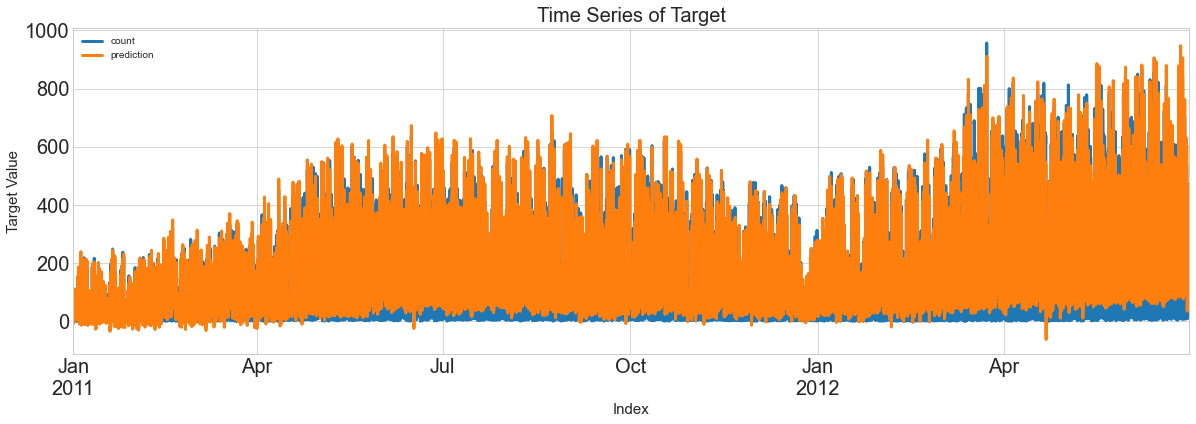

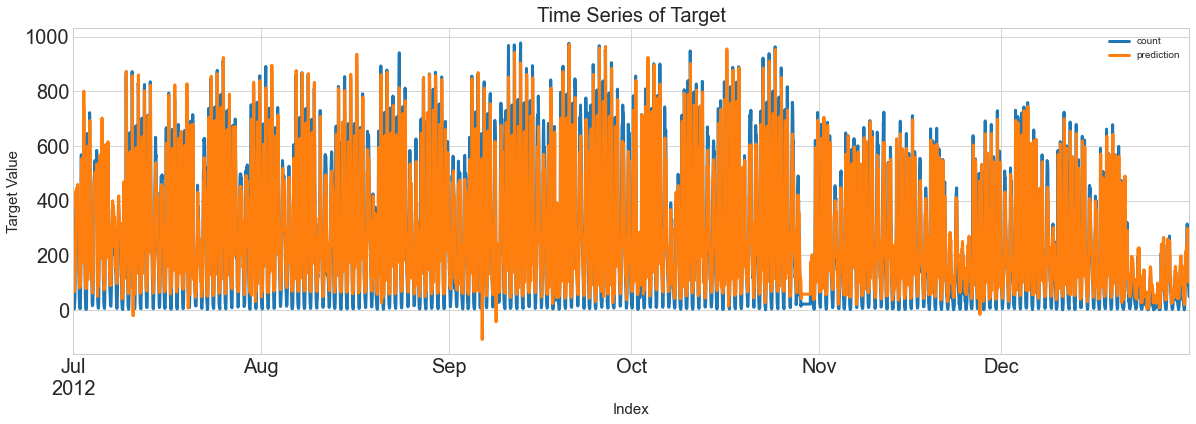

In [28]:
### Regularization
# Ridge
ridge_reg = Ridge(alpha=0.5, fit_intercept=True, normalize=False, random_state=123)
ridge_reg.fit(X_train, y_train)
X_ridge_pred = ridge_reg.predict(X_train).flatten()
y_ridge_pred = ridge_reg.predict(X_test).flatten()

# Evaluation
Score_reg2_feRSM, Resid_tr_reg2_feRSM, Resid_te_reg2_feRSM = evaluation_trte(y_train, X_ridge_pred,
                                                                   y_test, y_ridge_pred, graph_on=True)
display(Score_reg2_feRSM)

#### Lasso

In [30]:
# Lasso
lasso_reg = Lasso(alpha=0.5, fit_intercept=True, normalize=False, random_state=123)
lasso_reg.fit(X_train, y_train)
X_lasso_pred = lasso_reg.predict(X_train).flatten()
y_lasso_pred = lasso_reg.predict(X_test).flatten()

# Evaluation
lasso_trte_score, lasso_tr_resid, lasso_te_resid = evaluation_trte(y_train, X_lasso_pred,
                                                                   y_test, y_lasso_pred, graph_on=False)
display(lasso_trte_score)

,MAE,MSE,MAPE
Train,50.382964,5526.2...,143.25...
Test,74.846371,11550....,152.30...


#### ElasticNet

In [31]:
# ElasticNet
elastic_reg = ElasticNet(alpha=0.01, l1_ratio=1, fit_intercept=True, normalize=False, random_state=123)
elastic_reg.fit(X_train, y_train)
X_elastic_pred = elastic_reg.predict(X_train).flatten()
y_elastic_pred = elastic_reg.predict(X_test).flatten()

# Evaluation
Score_reg2_feRSM, Resid_tr_reg2_feRSM, Resid_te_reg2_feRSM = evaluation_trte(y_train, X_elastic_pred,
                                                                   y_test, y_elastic_pred, graph_on=False)
display(Score_reg2_feRSM)

,MAE,MSE,MAPE
Train,50.445812,5512.9...,143.91...
Test,74.463443,11507....,148.40...


### Bagging

#### DecisionTree

,MAE,MSE,MAPE
Train,0.000000,0.000000,0.000000
Test,39.675498,4060.8...,27.318983


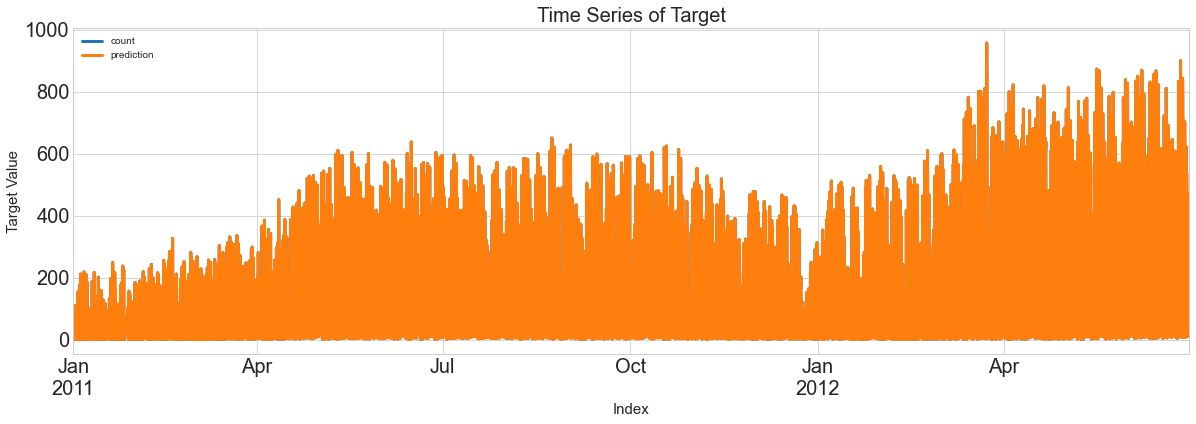

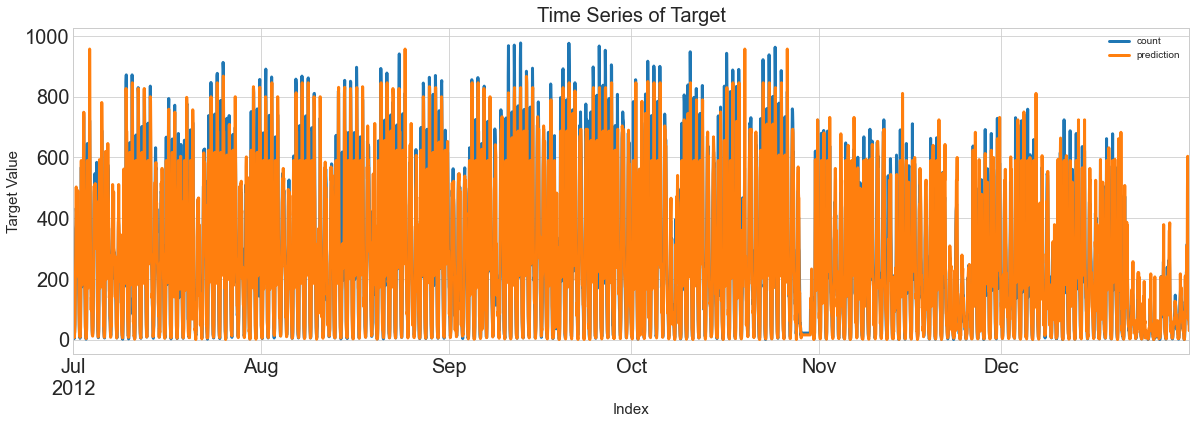

In [32]:
# DecisionTree
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)
X_dt_pred = dt_reg.predict(X_train)
y_dt_pred = dt_reg.predict(X_test)

# Evaluation
Score_reg2_feRSM, Resid_tr_reg2_feRSM, Resid_te_reg2_feRSM = evaluation_trte(y_train, X_dt_pred,
                                                                   y_test, y_dt_pred, graph_on=True)
display(Score_reg2_feRSM)

#### RandomForestRegressor

In [33]:
# RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=123)
rf_reg.fit(X_train, y_train)
X_rf_pred = rf_reg.predict(X_train)
y_rf_pred = rf_reg.predict(X_test)

# Evaluation
Score_reg2_feRSM, Resid_tr_reg2_feRSM, Resid_te_reg2_feRSM = evaluation_trte(y_train, X_rf_pred,
                                                                   y_test, y_rf_pred, graph_on=False)
display(Score_reg2_feRSM)

,MAE,MSE,MAPE
Train,7.020836,131.58...,9.543257
Test,30.074821,2308.6...,21.211131


### Boosting

#### GradientBoostingRegression

In [50]:
# GradientBoostingRegression
gb_reg = GradientBoostingRegressor(alpha=0.1, learning_rate=0.05, loss='huber', criterion='friedman_mse',
                                           n_estimators=1000, random_state=123)
gb_reg.fit(X_train, y_train)
X_gb_pred = gb_reg.predict(X_train)
y_gb_pred = gb_reg.predict(X_test)

# Evaluation
Score_reg2_feRSM, Resid_tr_reg2_feRSM, Resid_te_reg2_feRSM = evaluation_trte(y_train, X_gb_pred,
                                                                   y_test, y_gb_pred, graph_on=False)
display(Score_reg2_feRSM)

,MAE,MSE,MAPE
Train,21.622129,1314.9...,28.397592
Test,37.786017,3771.5...,25.489545


#### XGBRegressor

In [42]:
# XGBoost
xgb_reg = XGBRegressor(learning_rate=0.05, n_estimators=100, random_state=123)
xgb_reg.fit(X_train, y_train)
X_xgb_pred = xgb_reg.predict(X_train)
y_xgb_pred = xgb_reg.predict(X_test)

# Evaluation
Score_reg2_feRSM, Resid_tr_reg2_feRSM, Resid_te_reg2_feRSM = evaluation_trte(y_train, X_xgb_pred,
                                                                   y_test, y_xgb_pred, graph_on=False)
display(Score_reg2_feRSM)

,MAE,MSE,MAPE
Train,17.591331,720.453830,27.510594
Test,31.897061,2449.633576,24.293585


#### LGBMRegressor

In [43]:
# LightGMB
lgbm_reg = LGBMRegressor(learning_rate=0.05, n_estimators=100, random_state=123)
lgbm_reg.fit(X_train, y_train)
X_lgbm_pred = lgbm_reg.predict(X_train)
y_lgbm_pred = lgbm_reg.predict(X_test)

# Evaluation
Score_reg2_feRSM, Resid_tr_reg2_feRSM, Resid_te_reg2_feRSM = evaluation_trte(y_train, X_lgbm_pred,
                                                                   y_test, y_lgbm_pred, graph_on=False)
display(Score_reg2_feRSM)

,MAE,MSE,MAPE
Train,18.844475,797.094503,39.638602
Test,30.800417,2329.577632,26.253572


### 중요도 보기
- 중요도가 제공되는 5가지 모델
  - gb_clf_imp = pd.DataFrame({'Feature':X.columns, 'gb_clf importance':gb_clf.feature_importances_})
  - xgb_clf_imp = pd.DataFrame({'Feature':X.columns, 'xgb_clf importance':xgb_clf.feature_importances_})
  - rf_clf_imp = pd.DataFrame({'Feature':X.columns, 'rf_clf importance':rf_clf.feature_importances_})
  - ext_clf_imp = pd.DataFrame({'Feature':X.columns, 'ext_clf importance':ext_clf.feature_importances_})
  - ada_clf_imp = pd.DataFrame({'Feature':X.columns, 'ada_clf importance':ada_clf.feature_importances_})

#### randomforest 중요도

,importance
count_lag1,0.760593
Hour,0.148674
count_lag2,0.031928
workingday,0.014958
Quater_ver2,0.009171
DayofWeek,0.008721
humidity,0.004274
atemp,0.003812
temp,0.003494
Day,0.003084


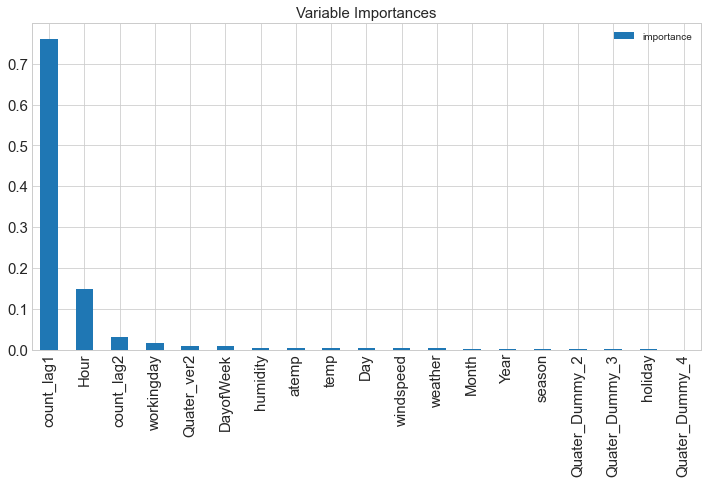

In [39]:
# Prediction Effect of Variables
Variable_Importances = pd.DataFrame([rf_reg.feature_importances_], 
                                    columns=X_train.columns, 
                                    index=['importance']).T.sort_values(by=['importance'], ascending=False)
display(Variable_Importances)
Variable_Importances.plot.bar(figsize=(12,6), fontsize=15)
plt.title('Variable Importances', fontsize=15)
plt.show()

#### XGBRegressor 중요도

,importance
count_lag1,0.629394
Hour,0.090418
Quater_ver2,0.073637
workingday,0.055832
count_lag2,0.054094
Year,0.031046
DayofWeek,0.012452
atemp,0.010582
weather,0.009137
temp,0.007929


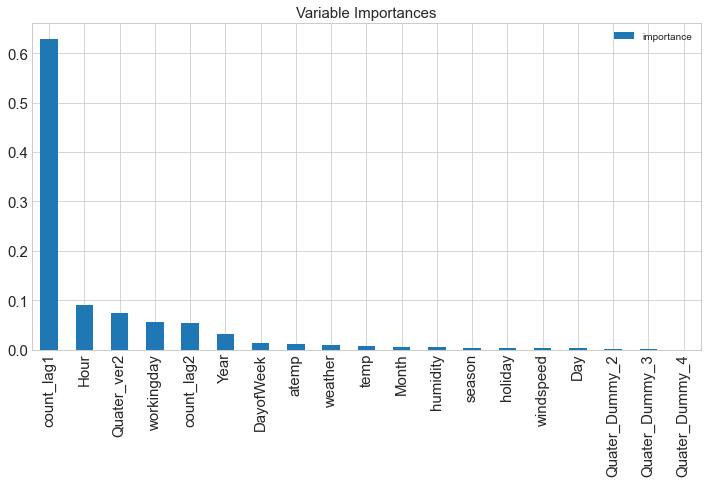

In [44]:
# Prediction Effect of Variables
Variable_Importances = pd.DataFrame([xgb_reg.feature_importances_], 
                                    columns=X_train.columns, 
                                    index=['importance']).T.sort_values(by=['importance'], ascending=False)
display(Variable_Importances)
Variable_Importances.plot.bar(figsize=(12,6), fontsize=15)
plt.title('Variable Importances', fontsize=15)
plt.show()

## Y예측을 위한 TS분석 실행

### ARMAX

In [47]:
# LinearRegression (using statsmodels)
fit_reg1 = sm.OLS(y_train, X_train).fit()
display(fit_reg1.summary())
pred_tr_reg1 = fit_reg1.predict(X_train).values
pred_te_reg1 = fit_reg1.predict(X_test).values

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     2685.
Date:                Sun, 05 Sep 2021   Prob (F-statistic):               0.00
Time:                        15:52:11   Log-Likelihood:                -75176.
No. Observations:               13128   AIC:                         1.504e+05
Df Residuals:                   13109   BIC:                         1.505e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season             4.6606      1.362      3.423      0.001       1.991       7.330
holiday           -8.3125      4.802     -1.731      0.083     -17.724       1.099
workingday         1.3448      2.353      0.571      0.568      -3.268       5.957
weather           -4.3785      1.138     -3.846      0.000      -6.610      -2.147
temp               2.7723      0.736      3.768      0.000       1.330       4.214
atemp              0.0929      0.650      0.143      0.886      -1.181       1.366
humidity          -0.5455      0.042    -13.057      0.000      -0.627      -0.464
windspeed         -0.0352      0.086     -0.407      0.684      -0.205       0.134
Year              -0.0020      0.003     -0.726      0.468      -0.007       0.003
Quater_ver2        7.0397      0.420     16.753      0.000       6.216       7.863
Month              1.1677      0.832      1.403      0.161      -0.463       2.799
Day               -0.1161      0.075     -1.550      0.121      -0.263       0.031
Hour               1.8814      0.115     16.315      0.000       1.655       2.107
DayofWeek          0.4267      0.539      0.791      0.429      -0.631       1.484
count_lag1         1.1148      0.008    142.876      0.000       1.100       1.130
count_lag2        -0.4876      0.008    -60.909      0.000      -0.503      -0.472
Quater_Dummy_2    -9.2823      3.205     -2.896      0.004     -15.565      -2.999
Quater_Dummy_3   -33.0960      5.681     -5.825      0.000     -44.232     -21.960
Quater_Dummy_4   -26.1878      8.305     -3.153      0.002     -42.466      -9.910
==============================================================================
Omnibus:                     2014.519   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11636.154
Skew:                           0.611   Prob(JB):                         0.00
Kurtosis:                       7.448   Cond. No.                     3.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
import requests
from io import BytesIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

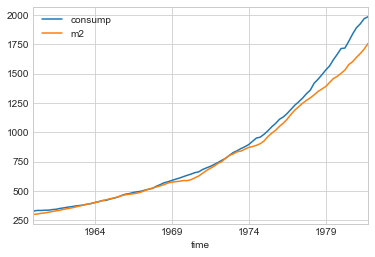

In [58]:
# 데이터 로딩 및 확인
source_url = requests.get('http://www.stata-press.com/data/r12/friedman2.dta').content
raw = pd.read_stata(BytesIO(source_url))
raw.index = raw.time
raw_using = raw.loc['1960':'1981',["consump", "m2"]]
raw_using.plot()
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     2685.
Date:                Sun, 05 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:30:38   Log-Likelihood:                -75176.
No. Observations:               13128   AIC:                         1.504e+05
Df Residuals:                   13109   BIC:                         1.505e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season             4.6606      1.362      3.423      0.001       1.991       7.330
holiday           -8.3125      4.802     -1.731      0.083     -17.724       1.099
workingday         1.3448      2.353      0.571      0.568      -3.268       5.957
weather           -4.3785      1.138     -3.846      0.000      -6.610      -2.147
temp               2.7723      0.736      3.768      0.000       1.330       4.214
atemp              0.0929      0.650      0.143      0.886      -1.181       1.366
humidity          -0.5455      0.042    -13.057      0.000      -0.627      -0.464
windspeed         -0.0352      0.086     -0.407      0.684      -0.205       0.134
Year              -0.0020      0.003     -0.726      0.468      -0.007       0.003
Quater_ver2        7.0397      0.420     16.753      0.000       6.216       7.863
Month              1.1677      0.832      1.403      0.161      -0.463       2.799
Day               -0.1161      0.075     -1.550      0.121      -0.263       0.031
Hour               1.8814      0.115     16.315      0.000       1.655       2.107
DayofWeek          0.4267      0.539      0.791      0.429      -0.631       1.484
count_lag1         1.1148      0.008    142.876      0.000       1.100       1.130
count_lag2        -0.4876      0.008    -60.909      0.000      -0.503      -0.472
Quater_Dummy_2    -9.2823      3.205     -2.896      0.004     -15.565      -2.999
Quater_Dummy_3   -33.0960      5.681     -5.825      0.000     -44.232     -21.960
Quater_Dummy_4   -26.1878      8.305     -3.153      0.002     -42.466      -9.910
==============================================================================
Omnibus:                     2014.519   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11636.154
Skew:                           0.611   Prob(JB):                         0.00
Kurtosis:                       7.448   Cond. No.                     3.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

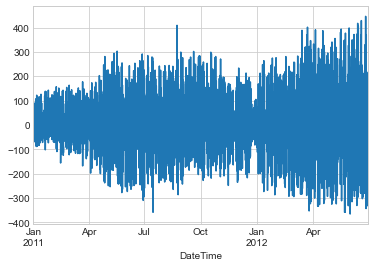

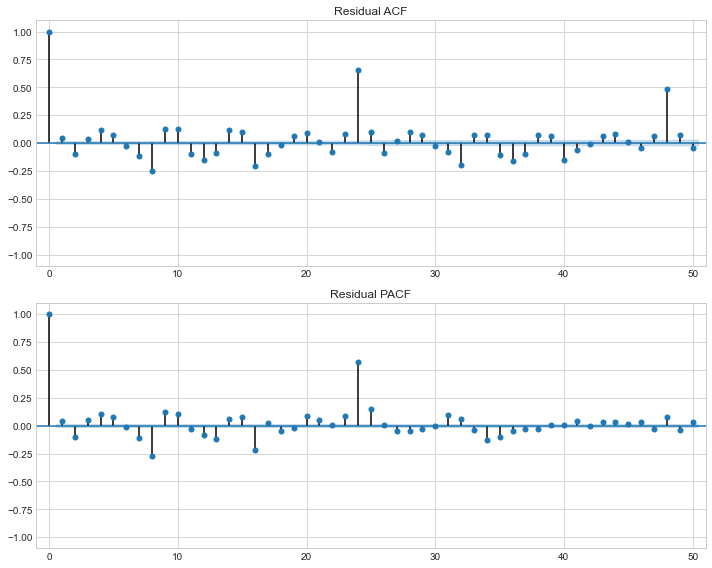

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  count   No. Observations:                13128
Model:                     ARMA(1, 1)   Log Likelihood              -75088.566
Method:                       css-mle   S.D. of innovations             73.758
Date:                Sun, 05 Sep 2021   AIC                         150223.131
Time:                        16:31:16   BIC                         150395.229
Sample:                    01-01-2011   HQIC                        150280.606
                         - 06-30-2012                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0234        nan        nan        nan         nan         nan
season             4.7657      1.602      2.975      0.003       1.626       7.905
holiday           -8.5314      5.607     -1.522      0.128     -19.521       2.458
workingday         1.4549      2.750      0.529      0.597      -3.935       6.844
weather           -4.2771      1.266     -3.379      0.001      -6.758      -1.796
temp               3.0745      0.833      3.690      0.000       1.442       4.708
atemp              0.0570      0.730      0.078      0.938      -1.373       1.487
humidity          -0.6061      0.052    -11.680      0.000      -0.708      -0.504
windspeed          0.0044      0.097      0.045      0.964      -0.185       0.194
Year              -0.0007        nan        nan        nan         nan         nan
Quater_ver2        7.4398        nan        nan        nan         nan         nan
Month              1.0464      0.977      1.071      0.284      -0.868       2.961
Day               -0.1227      0.088     -1.394      0.163      -0.295       0.050
Hour               1.7586      0.128     13.688      0.000       1.507       2.010
DayofWeek          0.4169      0.630      0.662      0.508      -0.818       1.652
count_lag1         0.9625      0.035     27.459      0.000       0.894       1.031
count_lag2        -0.3594      0.025    -14.291      0.000      -0.409      -0.310
Quater_Dummy_2    -9.5327        nan        nan        nan         nan         nan
Quater_Dummy_3   -34.4168        nan        nan        nan         nan         nan
Quater_Dummy_4   -25.3928        nan        nan        nan         nan         nan
ar.L1.count       -0.1277      0.100     -1.283      0.199      -0.323       0.067
ma.L1.count        0.3352      0.068      4.913      0.000       0.201       0.469
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -7.8298           +0.0000j            7.8298            0.5000
MA.1           -2.9829           +0.0000j            2.9829            0.5000
-----------------------------------------------------------------------------
"""

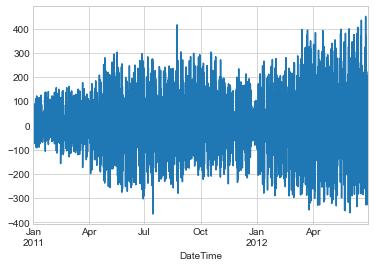

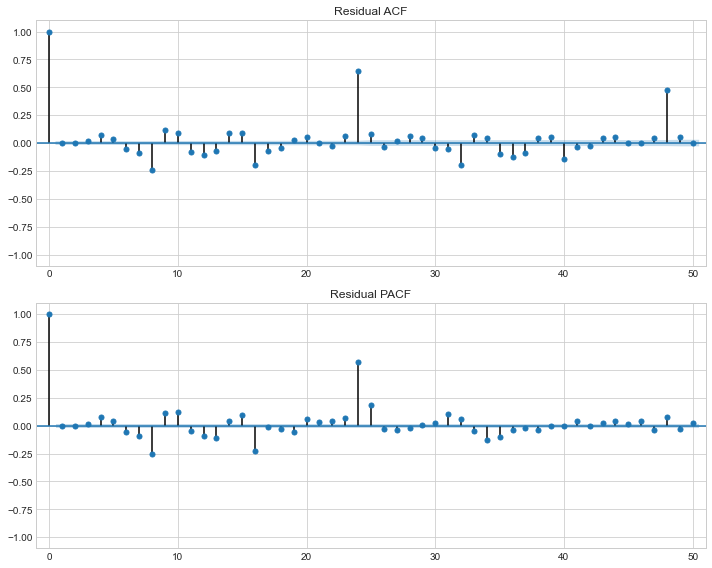

In [74]:
# 모델링
## 회귀분석
fir_reg1 = sm.OLS(y_train, X_train).fit()
display(fir_reg1.summary())

## 잔차 확인
fir_reg1.resid.plot()
plt.show()

## 잔차 ACF/PACF
plt.figure(figsize=(10, 8))
sm.graphics.tsa.plot_acf(fir_reg1.resid, lags=50, ax=plt.subplot(211))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Residual ACF")

sm.graphics.tsa.plot_pacf(fir_reg1.resid, lags=50, ax=plt.subplot(212))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Residual PACF")
plt.tight_layout()
plt.show()





# 모델링
## ARIMAX
# exog에 넣을 X_train의 컬럼 뽑기
exog_tr = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'Year', 'Quater_ver2', 'Month', 'Day', 'Hour',
       'DayofWeek', 'count_lag1', 'count_lag2', 'Quater_Dummy_2',
       'Quater_Dummy_3', 'Quater_Dummy_4']
exog_te = []
fit_reg2 = sm.tsa.ARMA(y_train, (1,1), exog=X_train[exog_tr]).fit()
display(fit_reg2.summary())

## 잔차 확인
fit_reg2.resid.plot()
plt.show()

## 잔차 ACF/PACF
plt.figure(figsize=(10, 8))
sm.graphics.tsa.plot_acf(fit_reg2.resid, lags=50, ax=plt.subplot(211))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Residual ACF")

sm.graphics.tsa.plot_pacf(fit_reg2.resid, lags=50, ax=plt.subplot(212))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Residual PACF")
plt.tight_layout()
plt.show()

### ARIMAX
* ACF, PACF가 잘 적합될 경우 파라미터마다 나오는 그래프를 알고 있어야 함

### SARIMAX(그래프가 차수별로 어떻게 나오는지 봐야 함, 프린트 하는 것도 좋을 것 같음)
- AIC, BIC가 낮은걸로 적합도를 확인함

#### 첫번째 모델링

In [ ]:
# 데이터 준비
data = sm.datasets.get_rdataset("AirPassengers")
raw = data.data.copy()

# 데이터 전처리
## 시간 인덱싱
if 'time' in raw.columns:
    raw.index = pd.date_range(start='1/1/1949', periods=len(raw['time']), freq='M')
    del raw['time']

## 정상성 확보
plt.figure(figsize=(12,8))
raw.plot(ax=plt.subplot(221), title='Y', legend=False)
np.log(raw).plot(ax=plt.subplot(222), title='log(Y)', legend=False)
raw.diff(1).plot(ax=plt.subplot(223), title='diff1(Y)', legend=False)
np.log(raw).diff(1).plot(ax=plt.subplot(224), title='diff1(log(Y))', legend=False)
plt.show()

In [ ]:
# 데이터로딩 및 확인
data = sm.datasets.get_rdataset("deaths", "MASS")
raw = data.data
raw.value = np.log(raw.value)
raw.plot(x='time', y='value')
plt.show()

# ACF/PACF 확인
plt.figure(figsize=(10, 8))
sm.graphics.tsa.plot_acf(raw.value.values, lags=50, ax=plt.subplot(211))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("ACF")

sm.graphics.tsa.plot_pacf(raw.value.values, lags=50, ax=plt.subplot(212))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("PACF")
plt.tight_layout()
plt.show()

# ARMA(1,1) 모델링
fit = sm.tsa.SARIMAX(raw.value, trend='c', order=(1,0,1), seasonal_order=(0,0,0,0)).fit()
display(fit.summary())

# 잔차진단
fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.show()

In [ ]:
# ARIMA 모델링 (raw)
fit = sm.tsa.SARIMAX(raw.value, trend='c', order=(1,1,1), seasonal_order=(0,0,0,0)).fit()
display(fit.summary())

# 잔차진단
fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.show()

In [ ]:
# ARIMA 모델링 (log(raw))
fit = sm.tsa.SARIMAX(np.log(raw.value), trend='c', order=(1,1,1), seasonal_order=(0,0,0,0)).fit()
display(fit.summary())

# 잔차진단
fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.show()

#### (이걸로 돌리기)두번째 모델링(전체 실행하는 것이라고 보면 됨)

In [27]:
X_train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'Year', 'Quater_ver2', 'Month', 'Day', 'Hour',
       'DayofWeek', 'count_lag1', 'count_lag2', 'Quater_Dummy_2',
       'Quater_Dummy_3', 'Quater_Dummy_4'],
      dtype='object')

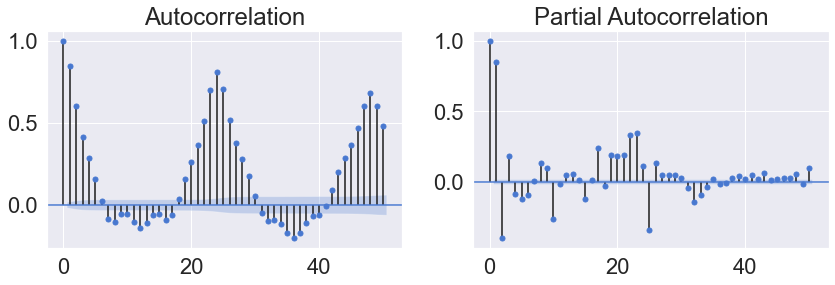

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                count   No. Observations:                13128
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood              -73817.473
Date:                              Sun, 05 Sep 2021   AIC                         147652.946
Time:                                      21:04:10   BIC                         147720.288
Sample:                                  01-01-2011   HQIC                        147675.436
                                       - 06-30-2012                                         
Covariance Type:                                opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0115      1.364      0.008      0.993      -2.661       2.684
DayofWeek         -0.7873      3.418     -0.230      0.818      -7.485       5.911
count_lag1         0.4328      0.030     14.543      0.000       0.375       0.491
count_lag2        -0.2694      0.016    -16.422      0.000      -0.302      -0.237
Quater_Dummy_2     8.0880    150.706      0.054      0.957    -287.290     303.466
ar.L1             -0.1588      0.030     -5.222      0.000      -0.218      -0.099
ar.S.L12          -0.9998      0.000  -5400.716      0.000      -1.000      -0.999
ma.S.L12           0.9826      0.002    642.472      0.000       0.980       0.986
sigma2          4477.6076     36.890    121.379      0.000    4405.305    4549.910
===================================================================================
Ljung-Box (Q):                    11363.76   Jarque-Bera (JB):             10014.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.54   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,MAE,MSE,MAPE
Train,44.980955,4475.297116,102.002039
Test,97.759651,16187.422183,219.266543


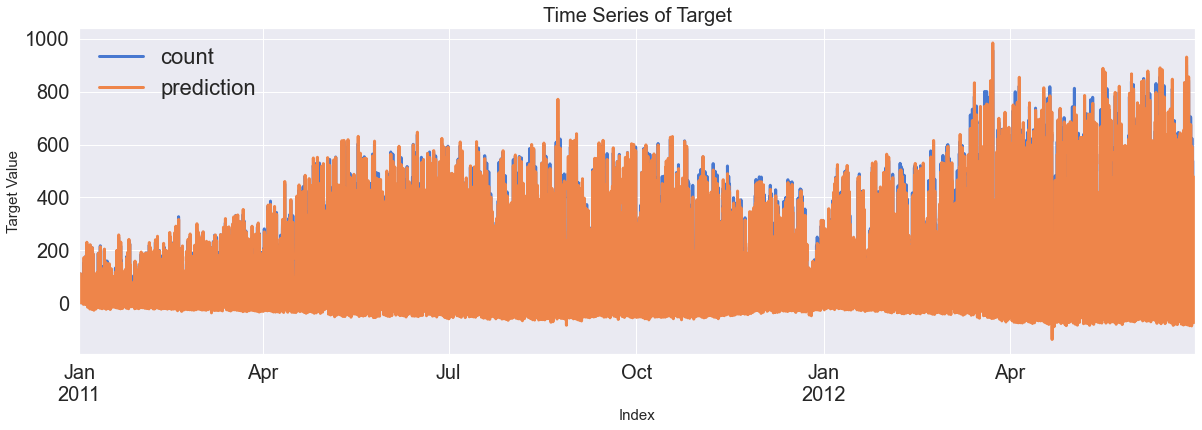

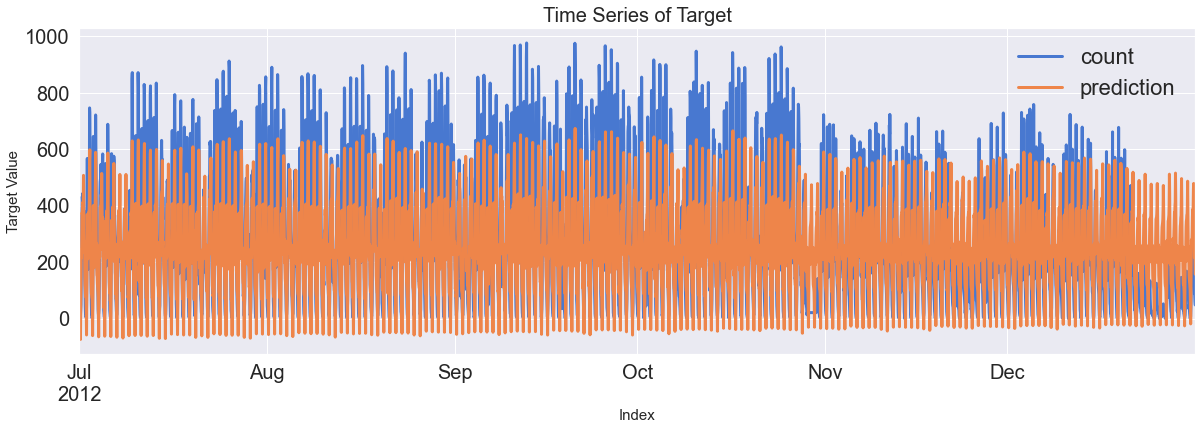

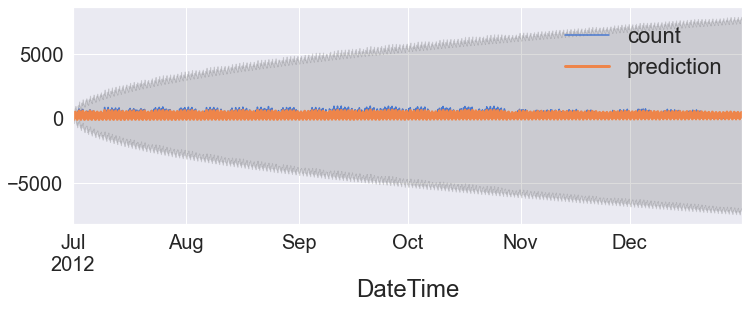

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-28.002189,0.002123,0.929863,0.622144,6.879095e+02,2630.577867,12256.599101,1.69477
p-value,0.000000,0.100000,0.000000,0.430252,2.020031e-146,0.000000,0.000000,3.57528e-100
Used Lag,41.000000,41.000000,NaN,NaN,NaN,NaN,NaN,NaN
Used Observations,13086.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Critical Value(1%),-3.430850,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Maximum Information Criteria,139388.669436,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Critical Value(10%),NaN,0.347000,NaN,NaN,NaN,NaN,NaN,NaN
Alternative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,two-sided


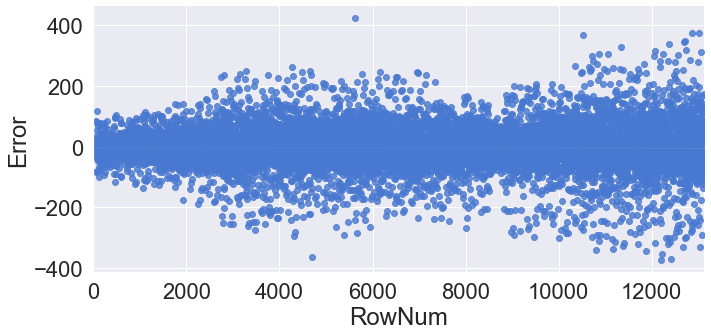

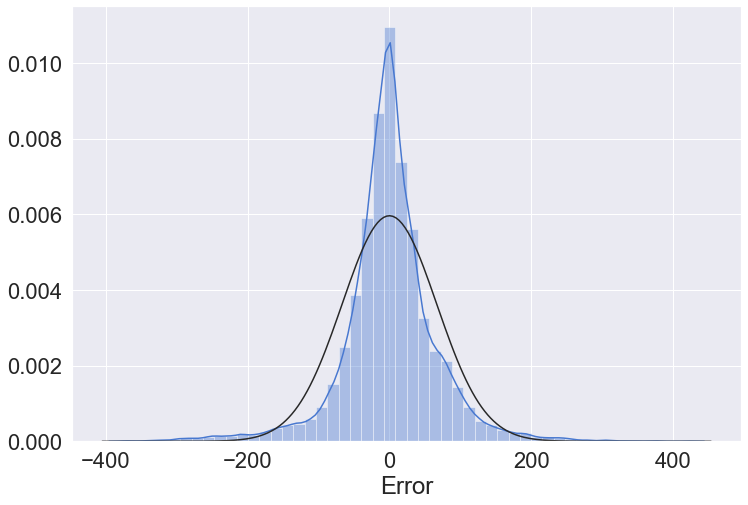

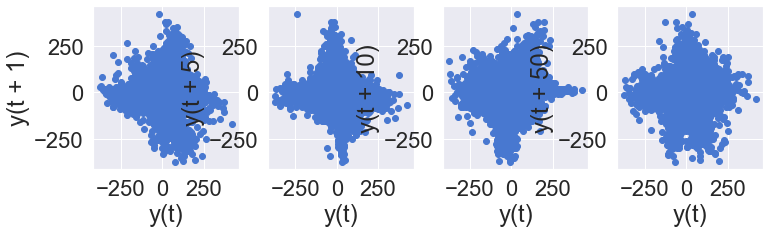

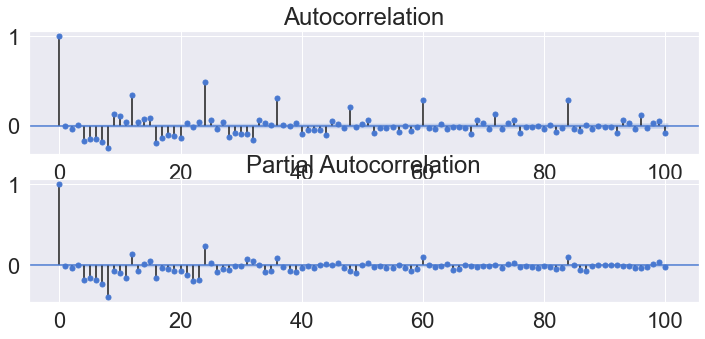

In [29]:
## 최종 타겟 선정 및 Train/Test 데이터 분리
# candidate = candidate_trend.copy()
# split_date = '1958-01-01'
# Y_train = candidate[candidate.index < split_date]
# Y_test = candidate[candidate.index >= split_date]

## 시각화 및 모수추론(p=1, q=0, d=1, P=1, Q=1, D(m)=12)
plt.figure(figsize=(14,4))
sm.tsa.graphics.plot_acf(y_train, lags=50, alpha=0.05, use_vlines=True, ax=plt.subplot(121))
sm.tsa.graphics.plot_pacf(y_train, lags=50, alpha=0.05, use_vlines=True, ax=plt.subplot(122))
plt.show()

# 모델링
## SARIMAX




### 파라미터 조정 ###
# 스케일링 돌리기
logarithm, differencing = False, False

# 이그자지너스 
exog_tr = X_train[['DayofWeek', 'count_lag1', 'count_lag2', 'Quater_Dummy_2']]
exog_te = X_test[['DayofWeek', 'count_lag1', 'count_lag2', 'Quater_Dummy_2']]

# 차분 넣기(트랜드)
p = 1
d = 1
q = 0

# 차분 넣기(트랜드)
P = 1
D = 0
Q = 1
seasonal_diff_order = 12
#############################



# SARIMAX(y_train, / exog=exog_te, exog=exog_te 이 3개를 스케일링 할때마다 같이 바꿔줘서 예측해야 함
sarimax_reg = sm.tsa.SARIMAX(y_train, order=(p,d,q), 
                                seasonal_order=(P,D,Q,seasonal_diff_order), trend='c', exog=exog_tr).fit()
display(sarimax_reg.summary())
sarimax_reg = sarimax_reg.predict()
sarimax_pred = sarimax_reg.get_forecast(len(y_test), exog=exog_te).predicted_mean
sarimax_pred_ci = sarimax_reg.get_forecast(len(y_test), exog=exog_te).conf_int()

## 비정상성으로 변환
if logarithm:
    Y_train = np.exp(y_train).copy()
    Y_test = np.exp(y_test).copy()
    pred_tr_ts_sarimax = np.exp(pred_tr_ts_sarimax).copy()
    pred_te_ts_sarimax = np.exp(pred_te_ts_sarimax).copy()
    pred_te_ts_sarimax_ci = np.exp(pred_te_ts_sarimax_ci).copy()
if differencing:
    pred_tr_ts_sarimax = np.cumsum(pred_tr_ts_sarimax).copy()
    
# 검증
%reload_ext autoreload
%autoreload 2

Score_ts_sarimax, Resid_tr_ts_sarimax, Resid_te_ts_sarimax = evaluation_trte(y_train, pred_tr_ts_sarimax, 
                                                                             y_test, pred_te_ts_sarimax, graph_on=True)
display(Score_ts_sarimax)
ax = pd.DataFrame(y_test).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_sarimax, index=y_test.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(y_test.index.min(),y_test.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=y_test.index).index,
                pd.DataFrame(pred_te_ts_sarimax_ci, index=y_test.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_sarimax_ci, index=y_test.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

# 잔차진단
error_analysis(Resid_tr_ts_sarimax, ['Error'], y_train, graph_on=True)

#### auto_SARIMAX(스케일링부터 전체)

In [ ]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)

### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')

### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############

### Scaling ###
X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)
###############

In [ ]:
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_feRS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_feRS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_feRSM, X_test_feRSM = X_train[X_colname_vif].copy(), X_test_feRS[X_colname_vif].copy()

### 모델링 ###
## Additional Features
exog_tr = X_train_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]
exog_te = X_test_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]                             
## Parameter Setting
p, q = range(1,3), range(1,3)
d = range(0,1)
P, Q = range(1,3), range(1,3)
D = range(1,2)
m = 12
trend_pdq = list(product(p, d, q))
seasonal_pdq = [(candi[0], candi[1], candi[2], m) for candi in list(product(P, D, Q))]
## SARIMAX

logarithm, differencing = True, False

AIC = []
SARIMAX_order = []
for trend_param in tqdm(trend_pdq):
    for seasonal_params in seasonal_pdq:
        try:
            result =sm.tsa.SARIMAX(Y_train_feR, trend='c', 
                                   order=trend_param, seasonal_order=seasonal_params, exog=exog_tr).fit()
            print('Fit SARIMAX: trend_order={} seasonal_order={} AIC={}, BIC={}'.format(trend_param, seasonal_params, result.aic, result.bic, end='\r'))
            AIC.append(result.aic)
            SARIMAX_order.append([trend_param, seasonal_params])
        except:
            continue
## Parameter Selection
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_order[AIC.index(min(AIC))][0],
                                                             SARIMAX_order[AIC.index(min(AIC))][1]))
## Auto-SARIMAX Fitting

fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, trend='c', order=SARIMAX_order[AIC.index(min(AIC))][0], 
                                seasonal_order=SARIMAX_order[AIC.index(min(AIC))][1], exog=exog_tr).fit()
display(fit_ts_sarimax.summary())
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_te_ts_sarimax = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=exog_te).predicted_mean
pred_te_ts_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=exog_te).conf_int()

## 비정상성으로 변환
if logarithm:
    Y_train = np.exp(Y_train).copy()
    Y_test = np.exp(Y_test).copy()
    pred_tr_ts_sarimax = np.exp(pred_tr_ts_sarimax).copy()
    pred_te_ts_sarimax = np.exp(pred_te_ts_sarimax).copy()
    pred_te_ts_sarimax_ci = np.exp(pred_te_ts_sarimax_ci).copy()
if differencing:
    pred_tr_ts_sarimax = np.cumsum(pred_tr_ts_sarimax).copy()

# 검증
Score_ts_sarimax, Resid_tr_ts_sarimax, Resid_te_ts_sarimax = evaluation_trte(Y_train_feR, pred_tr_ts_sarimax, 
                                                                             Y_test_feR, pred_te_ts_sarimax, graph_on=True)
display(Score_ts_sarimax)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_sarimax, index=Y_test_feR.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).index,
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

# 잔차진단
error_analysis(Resid_tr_ts_sarimax, ['Error'], Y_train_feR, graph_on=True)

In [ ]:
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_feRSM, X_test_feRSM = X_train[X_colname_vif].copy(), X_test[X_colname_vif].copy()

### 모델링 ###
## Additional Features
exog_tr = X_train[['weather', 'count_lag2', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]
exog_te = X_test[['weather', 'count_lag2', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]                             
## Parameter Setting
p, q = range(1,3), range(1,3)
d = range(0,1)
P, Q = range(1,3), range(1,3)
D = range(1,2)
m = 12
trend_pdq = list(product(p, d, q))
seasonal_pdq = [(candi[0], candi[1], candi[2], m) for candi in list(product(P, D, Q))]
## SARIMAX

logarithm, differencing = True, False

AIC = []
SARIMAX_order = []
for trend_param in tqdm(trend_pdq):
    for seasonal_params in seasonal_pdq:
        try:
            result =sm.tsa.SARIMAX(y_train, trend='c', 
                                   order=trend_param, seasonal_order=seasonal_params, exog=exog_tr).fit()
            print('Fit SARIMAX: trend_order={} seasonal_order={} AIC={}, BIC={}'.format(trend_param, seasonal_params, result.aic, result.bic, end='\r'))
            AIC.append(result.aic)
            SARIMAX_order.append([trend_param, seasonal_params])
        except:
            continue
## Parameter Selection
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_order[AIC.index(min(AIC))][0],
                                                             SARIMAX_order[AIC.index(min(AIC))][1]))
## Auto-SARIMAX Fitting

fit_ts_sarimax = sm.tsa.SARIMAX(y_train, trend='c', order=SARIMAX_order[AIC.index(min(AIC))][0], 
                                seasonal_order=SARIMAX_order[AIC.index(min(AIC))][1], exog=exog_tr).fit()
display(fit_ts_sarimax.summary())
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_te_ts_sarimax = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=exog_te).predicted_mean
pred_te_ts_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=exog_te).conf_int()

## 비정상성으로 변환
if logarithm:
    Y_train = np.exp(y_train).copy()
    Y_test = np.exp(y_test).copy()
    pred_tr_ts_sarimax = np.exp(pred_tr_ts_sarimax).copy()
    pred_te_ts_sarimax = np.exp(pred_te_ts_sarimax).copy()
    pred_te_ts_sarimax_ci = np.exp(pred_te_ts_sarimax_ci).copy()
if differencing:
    pred_tr_ts_sarimax = np.cumsum(pred_tr_ts_sarimax).copy()

# 검증
Score_ts_sarimax, Resid_tr_ts_sarimax, Resid_te_ts_sarimax = evaluation_trte(y_train, pred_tr_ts_sarimax, 
                                                                             y_train, pred_te_ts_sarimax, graph_on=True)
display(Score_ts_sarimax)
ax = pd.DataFrame(y_test).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_sarimax, index=y_test.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(y_train.index.min(),y_test.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=y_test.index).index,
                pd.DataFrame(pred_te_ts_sarimax_ci, index=y_test.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_sarimax_ci, index=y_test.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

# 잔차진단
error_analysis(Resid_tr_ts_sarimax, ['Error'], y_train, graph_on=True)

Number_of_Total_X:  19


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Number_of_Selected_X:  12
Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(1, 1, 1, 12) AIC=144727.61143193935, BIC=144817.39048959492
Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(1, 1, 2, 12) AIC=141830.1678957495, BIC=141927.42854154305
Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(2, 1, 1, 12) AIC=142171.44938078613, BIC=142268.71002657968


## 잔차진단(미완)
* 통계량
  - ***Stationarity_adf*** : 
    - 의사결정 : ***p-value < 0.05***
    - 가설확인 : H0 = 비정상 상태이다 / H1 = 정상 상태이다. 
    - ADF 정상성 확인(추세 제거 확인용) / ADF 검정통계량은 정상이라고 해도 데이터에 계절성이 포함되면 ACF의 비정상 Lag 존재하는 비정상데이터 가능
    _ 종류 : ADF-GLS test, Phillips-Perron(PP) test(ADF와 동일) / Kwiatkowski Phillips Schmidt Shin(KPSS) test(ADF와 반대)
  - ***Stationarity_kpss*** : 
    - 의사결정 : ***p-value >= 0.05***
    - 가설확인 : H0 = 정상 상태이다 / H1 = 비정상 상태이다. 
    - KPSS 정상성 확인(계절성 제거 확인용) / KPSS 검정통계량은 정상이라고 해도 데이터에 추세가 포함되면 ACF의 비정상 Lag 존재하는 비정상데이터 가능
  - ***Normality*** :
    - 의사결정 : ***p-value >= 0.05***
    - 가설확인 : H0 = 정규분포 형태이다 / H1 = 정규분포가 아닌 형태이다. 
    - 종류 : Shapiro_Wilk test, Kolmogorov-Smirnov test, Lilliefors teset, Anderson_Darling test, Jarque-Bera test, Pearson's chi-squared test, D'Agostino's K-squared test (가설확인 모두 동일)
  - **Autocorr(lag1, lag5, lag10, lag50)** : 자기상관, 잔차의 독립성
    - 의사결정 : ***p-value >= 0.05***
    - 가설확인 : H0 = 시계열 데이터의 Autocorrelation은 0이다.(존재하지 않는다) / H1 = 0이 아니다(존재한다). 
    - 종류 : Ljung-Box test, Portmanteau test, Breusch-Godfrey test, Durbin-Watson statistic (Ljung-Box와 동일)
  - ***Heteroscedasticity*** :
    - 의사결정 : ***p-value < 0.05***
    - 가설확인 : H0 = 시계열 데이터의 Homoscedasticity 상태다(등분산이다.) / H1 = 등분산이 아니다. 
    - 종류 : Goldfeld-Quandt test, Breuch-Pagan test, Bartlett's test (가설확인 모두 동일)
    
* 그래프
  - ACF : MA(q)에서 q번째까지 ACF 그래프에서 튀는 개수 / ARMA(p,q)에서 q번째까지 지수적 감소 혹은 진동하는 형태
  - PACF : AR(p)에서 p번째까지 PACF 그래프에서 튀는 개수 / ARMA(p,q)에서 p번째까지 지수적 감소 혹은 진동하는 형태

### 함수

In [19]:
def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_test(Y_Data, Target_name)
    Stationarity_kpss = stationarity_kpss_test(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
    return Score
# error_analysis(Resid_tr_reg1[1:], ['Error'], X_train, graph_on=True)

In [ ]:
# Error Analysis(Plot)
Resid_tr_reg1['RowNum'] = Resid_tr_reg1.reset_index().index

# Stationarity(Trend) Analysis
sns.set(palette="muted", color_codes=True, font_scale=2)
sns.lmplot(x='RowNum', y='Error', data=Resid_tr_reg1.iloc[1:],
           fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)

# Normal Distribution Analysis
figure, axes = plt.subplots(figsize=(12,8))
sns.distplot(Resid_tr_reg1['Error'], norm_hist='True', fit=stats.norm)

# Lag Analysis
length = int(len(Resid_tr_reg1['Error'])/10)
figure, axes = plt.subplots(1, 4, figsize=(12,3))
pd.plotting.lag_plot(Resid_tr_reg1['Error'], lag=1, ax=axes[0])
pd.plotting.lag_plot(Resid_tr_reg1['Error'], lag=5, ax=axes[1])
pd.plotting.lag_plot(Resid_tr_reg1['Error'], lag=10, ax=axes[2])
pd.plotting.lag_plot(Resid_tr_reg1['Error'], lag=50, ax=axes[3])

# Autocorrelation Analysis
figure, axes = plt.subplots(2,1,figsize=(12,5))
figure = sm.graphics.tsa.plot_acf(Resid_tr_reg1['Error'], lags=100, use_vlines=True, ax=axes[0])
figure = sm.graphics.tsa.plot_pacf(Resid_tr_reg1['Error'], lags=100, use_vlines=True, ax=axes[1])

# Error Analysis(Statistics)
# Checking Stationarity
# Null Hypothesis: The Time-series is non-stationalry
Stationarity = pd.Series(sm.tsa.stattools.adfuller(Resid_tr_reg1['Error'])[0:4], index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
for key, value in sm.tsa.stattools.adfuller(Resid_tr_reg1['Error'])[4].items():
    Stationarity['Critical Value(%s)'%key] = value
Stationarity['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Resid_tr_reg1['Error'])[5]
Stationarity = pd.DataFrame(Stationarity, columns=['Stationarity'])

# Checking of Normality
# Null Hypothesis: The residuals are normally distributed
Normality = pd.DataFrame([stats.shapiro(Resid_tr_reg1['Error'])], index=['Normality'], columns=['Test Statistics', 'p-value']).T

# Checking for Autocorrelation
# Null Hypothesis: Autocorrelation is absent
Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Resid_tr_reg1['Error'], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                             pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Resid_tr_reg1['Error'], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

# Checking Heteroscedasticity
# Null Hypothesis: Error terms are homoscedastic
Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Resid_tr_reg1['Error'], X_train.values, alternative='two-sided')],
                                  index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
Error_Analysis = pd.concat([Stationarity, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
Error_Analysis = Error_Analysis.loc[['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                                     'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)',
                                     'Maximum Information Criteria'],:]
Error_Analysis

In [ ]:
error_analysis(Resid_tr_reg1, ['Error'], X_train, graph_on=True)
# 정상성 / 비정규분포 / 자기상관없음 / 등분산아님

### 두 번째 잔차진단

In [ ]:
# 잔차진단
fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.show()

# 실행

## Base 분석결과

### Raw Data

In [ ]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_rd = non_feature_engineering(raw_all)

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_rd.columns if x not in Y_colname+X_remove]
X_train_rd, X_test_rd, Y_train_rd, Y_test_rd = datasplit_ts(raw_rd, Y_colname, X_colname, '2012-07-01')

# Applying Base Model
fit_reg1_rd = sm.OLS(Y_train_rd, X_train_rd).fit()
display(fit_reg1_rd.summary())
pred_tr_reg1_rd = fit_reg1_rd.predict(X_train_rd).values
pred_te_reg1_rd = fit_reg1_rd.predict(X_test_rd).values

# Evaluation
Score_reg1_rd, Resid_tr_reg1_rd, Resid_te_reg1_rd = evaluation_trte(Y_train_rd, pred_tr_reg1_rd, 
                                                                Y_test_rd, pred_te_reg1_rd, graph_on=True)
display(Score_reg1_rd)

# Error Analysis
error_analysis(Resid_tr_reg1_rd, ['Error'], X_train_rd, graph_on=True)

### Feature Engineering Data

In [ ]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_fe, X_test_fe, Y_train_fe, Y_test_fe = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')

# Applying Base Model
fit_reg1_fe = sm.OLS(Y_train_fe, X_train_fe).fit()
display(fit_reg1_fe.summary())
pred_tr_reg1_fe = fit_reg1_fe.predict(X_train_fe).values
pred_te_reg1_fe = fit_reg1_fe.predict(X_test_fe).values

# Evaluation
Score_reg1_fe, Resid_tr_reg1_fe, Resid_te_reg1_fe = evaluation_trte(Y_train_fe, pred_tr_reg1_fe,
                                                                Y_test_fe, pred_te_reg1_fe, graph_on=True)
display(Score_reg1_fe)

# Error Analysis
error_analysis(Resid_tr_reg1_fe, ['Error'], X_train_fe, graph_on=True)